# Import des Librairies utiles au projet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numpy.random import RandomState
import scipy.stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

# A partir des différents datasets à notre disposition sur les courses de Formule 1, comment peut-on prédire quelle écurie gagnera la course ?

### Le dataset que nous avons utilisé est disponible à l'adresse suivante : https://www.kaggle.com/datasets/melissamonfared/formula-1/data
Les données que nous possédons proviennet de multiples jeux de données aux facteurs variés. Chacun d'entre eux contient des informations qu peuvent nous être utiles pour prédire le résultat de la course.

Notre jeu de données contient les csv suivants :
 1. Circuits
 2. Constructor results
 3. Constructor standings
 4. Constructors
 5. drivers
 6. driver standings
 7. Lap times
 8. Pit stops
 9. Qualifying
 10. Races
 11. Results
 12. Seasons
 13. Sprint results
 14. Status

Avant de passer à l'entraînement de notre model, il nous faut déjà visualiser une première fois nos données, pour identifier les variables qui ont le plus d'impacts, si certaines colonnes sont vides, si certaines données sont inutilisables, etc... Cette étape nous aidera à faire les démarches nécessaires au nettoyage de notre dataset afin qu'il soit le plus performant possible.

In [5]:
# Lecture rapide des csv

circuits_df = pd.read_csv('circuits.csv')
print("Circuits :\n", circuits_df.head())

constructor_results_df = pd.read_csv('constructor_results.csv')
print("Constructor_results :\n",constructor_results_df.head())

constructor_standings_df = pd.read_csv('constructor_standings.csv')
print("Constructor_standings :\n",constructor_standings_df.head())

constructors_df = pd.read_csv('constructors.csv')
print("Constructors :\n",constructors_df.head())

driver_standings_df = pd.read_csv('driver_standings.csv')
print("Driver_standings :\n",driver_standings_df.head())

drivers_df = pd.read_csv('drivers.csv')
print("Drivers :\n",drivers_df.head())

lap_times_df = pd.read_csv('lap_times.csv')
print("Lap_times :\n",lap_times_df.head())

pit_stops_df = pd.read_csv('pit_stops.csv')
print("Pit_stops :\n",pit_stops_df.head())

qualifying_df = pd.read_csv('qualifying.csv')
print("Qualifying :\n",qualifying_df.head())

races_df = pd.read_csv('races.csv')
print("Races :\n",races_df.head())

results_df = pd.read_csv('results.csv')
print("Results :\n",results_df.head())

seasons_df = pd.read_csv('seasons.csv')
print("Seasons :\n",seasons_df.head())

sprint_results_df = pd.read_csv('sprint_results.csv')
print("Sprint_results :\n",sprint_results_df.head())

status_df = pd.read_csv('status.csv')
print("Status :\n",status_df.head())

Circuits :
    circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.76083  101.73800   18   
2    Bahrain  26.03250   50.51060    7   
3      Spain  41.57000    2.26111  109   
4     Turkey  40.95170   29.40500  130   

                                                 url  
0  http://en.wikipedia.org/wiki/Melbourne_Grand_P...  
1  http://en.wikipedia.org/wiki/Sepang_Internatio...  
2  http://en.wikipedia.org/wiki/Bahrain_Internati...  
3  http://en.wikipedia.org/wiki/Circuit_de_Barcel...  
4        

# Audit de la qualité des données (Missing Values)

Ici nous regardons quelles sont les proportions de valeurs nulles et aux caractères spéciaux ('\\N') afin de s'en charger à l'avenir dans le preprocessing.

In [7]:
def audit_data_quality(dataframes_dict):
    """Vérifie les valeurs manquantes et les caractères spéciaux comme '\\N'."""
    print("--- Rapport de Qualité des Données ---")
    for name, df in dataframes_dict.items():
        print(f"\nJeu de données : {name.upper()}")
        print(f"Dimensions : {df.shape}")
        
        # Vérifier les NaN standards
        na_count = df.isna().sum().sum()
        
        # Vérifier les '\N' spécifiques à ce dataset Kaggle
        n_str_count = (df == '\\N').sum().sum()
        
        if na_count > 0 or n_str_count > 0:
            print(f"Valeurs NaN : {na_count}")
            print(f"Valeurs '\\N' : {n_str_count}")
            # Afficher les colonnes concernées
            cols_missing = df.columns[(df == '\\N').any() | df.isna().any()].tolist()
            print(f"Colonnes à nettoyer : {cols_missing}")
        else:
            print("Aucune valeur manquante détectée.")

audit_data_quality({
    'circuits': circuits_df,
    'constructor_results': constructor_results_df,
    'constructor_standings': constructor_standings_df,
    'constructors': constructors_df,
    'driver_standings': driver_standings_df,
    'drivers': drivers_df,
    'lap_times': lap_times_df,
    'pit_stops': pit_stops_df,
    'qualifying': qualifying_df,
    'races': races_df,
    'results': results_df,
    'seasons': seasons_df,
    'sprint_results': sprint_results_df,
    'status': status_df
})

--- Rapport de Qualité des Données ---

Jeu de données : CIRCUITS
Dimensions : (77, 9)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTOR_RESULTS
Dimensions : (12495, 5)
Valeurs NaN : 0
Valeurs '\N' : 12478
Colonnes à nettoyer : ['status']

Jeu de données : CONSTRUCTOR_STANDINGS
Dimensions : (13261, 7)
Aucune valeur manquante détectée.

Jeu de données : CONSTRUCTORS
Dimensions : (212, 5)
Aucune valeur manquante détectée.

Jeu de données : DRIVER_STANDINGS
Dimensions : (34574, 7)
Aucune valeur manquante détectée.

Jeu de données : DRIVERS
Dimensions : (859, 9)
Valeurs NaN : 0
Valeurs '\N' : 1559
Colonnes à nettoyer : ['number', 'code']

Jeu de données : LAP_TIMES
Dimensions : (575029, 6)
Aucune valeur manquante détectée.

Jeu de données : PIT_STOPS
Dimensions : (10945, 7)
Aucune valeur manquante détectée.

Jeu de données : QUALIFYING
Dimensions : (10234, 9)
Valeurs NaN : 40
Valeurs '\N' : 11424
Colonnes à nettoyer : ['q1', 'q2', 'q3']

Jeu de données : RACES
Dimensions : (1

Après cette première analyse rapide, nous nous appercevons que certains datasets contiennent de nombreuses colonnes aux données manquantes, certaines l'étant presque complètement (comme status avec 12478 nulls pour 12495 lignes). Il nous faudra donc traiter ces cas plus en profondeur en supprimant les lignes concernées par exemple ou en utilisant des techniques de Feature Engineering.

Nous allons commencer notre analyse de données en procédant à quelques analyses univariées et visualisations nous permettant de regarder un peu plus en profondeur nos données et d'en tirer de premières conclusions quand à leurs utilités sur notre modèle. Cela nous permettra également de procéder à une première étape de nettoyage.

### Extraction des datasets

Dans le script suivant nous automatisons  le chargement des 14 fichiers CSV en convertissant le symbole spécifique \N en données nulles (NaN). Cette étape est indispensable pour que la librairie Pandas reconnaisse nos données comme des nombres et non du texte. 
Ensuite nous extrayons ces données de notre dictionnaire vers des variables distinctes (comme results ou drivers) pour simplifier leur utilisation immédiate.

In [11]:
dataframes = {}
file_names = [
    "circuits.csv", "constructor_results.csv", "constructor_standings.csv",
    "constructors.csv", "driver_standings.csv", "drivers.csv",
    "lap_times.csv", "pit_stops.csv", "races.csv", "results.csv", "status.csv", 
    "qualifying.csv", "seasons.csv", "sprint_results.csv"
]
na_val = '\\N'

for f_name in file_names:
    try:
        key = f_name.split('.')[0]
        dataframes[key] = pd.read_csv(f_name, na_values=[na_val])
        print(f"Fichier '{f_name}' chargé.")
    except FileNotFoundError:
        # En cas de mauvaise écriture du csv ou non présence des fichiers dans le bon dossier
        print(f"ERREUR INATTENDUE : Fichier non trouvé : '{f_name}'")
        sys.exit()

#Extraire les datasets
results = dataframes.get('results')
races = dataframes.get('races')
circuits = dataframes.get('circuits')
drivers = dataframes.get('drivers')
constructors = dataframes.get('constructors')
driver_standings = dataframes.get('driver_standings')
constructor_standings = dataframes.get('constructor_standings')
constructor_results = dataframes.get('constructor_results')
status = dataframes.get('status')
lap_times = dataframes.get('lap_times')
pit_stops = dataframes.get('pit_stops')
status = dataframes.get('status')
qualifying = dataframes.get('qualifying')
seasons = dataframes.get('seasons')
sprint_results = dataframes.get('sprint_results')

Fichier 'circuits.csv' chargé.
Fichier 'constructor_results.csv' chargé.
Fichier 'constructor_standings.csv' chargé.
Fichier 'constructors.csv' chargé.
Fichier 'driver_standings.csv' chargé.
Fichier 'drivers.csv' chargé.
Fichier 'lap_times.csv' chargé.
Fichier 'pit_stops.csv' chargé.
Fichier 'races.csv' chargé.
Fichier 'results.csv' chargé.
Fichier 'status.csv' chargé.
Fichier 'qualifying.csv' chargé.
Fichier 'seasons.csv' chargé.
Fichier 'sprint_results.csv' chargé.


# Analyse Univariée et premiers nettoyages

Configuration du style pour les diagrammes, graphes et autres schémas utilisées pour la visualisation.

In [14]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

### Analyse des colonnes urls, lat, lng, alt, location et country de circuits

Dans ce dataset on remarque plusieurs colonnes qui ont l'air de ne pas apporter beaucoup d'informations pertinentes, ou contribuent même à de la redondance et à du bruit. Afin d'évaluer cela nous avons procédé à plusieurs visualisations de ces features pour en déduire, ou non, une certaine pertinence.

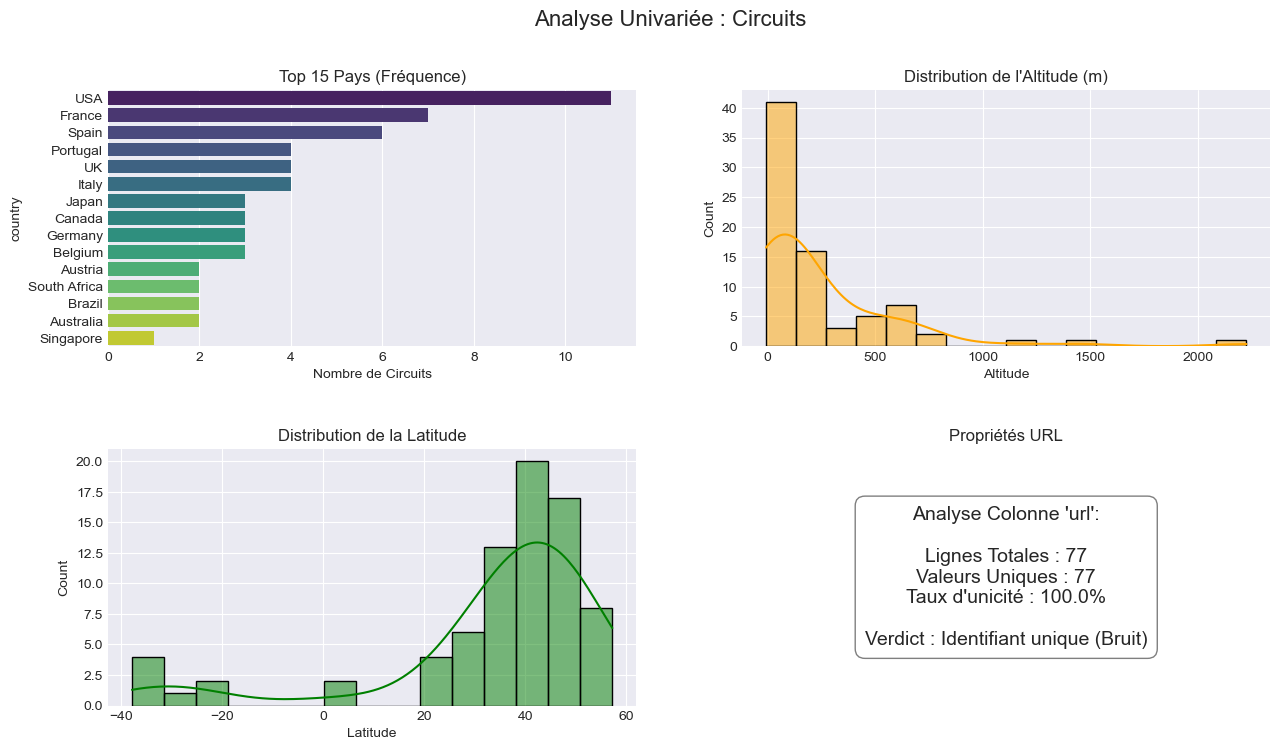

--- Statistiques Descriptives (Altitudes et Latitudes) ---
               alt        lat
count    77.000000  77.000000
mean    247.012987  33.442925
std     362.738469  22.808866
min      -7.000000 -37.849700
25%      18.000000  32.777400
50%     129.000000  40.951700
75%     332.000000  46.958900
max    2227.000000  57.265300


In [16]:
# Création des sous-graphiques
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.4)

# 1. Country (Top 15 pour lisibilité)
country_counts = circuits['country'].value_counts().head(15)
sns.barplot(x=country_counts.values, y=country_counts.index, hue=country_counts.index, legend=False, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 15 Pays (Fréquence)')
axes[0, 0].set_xlabel('Nombre de Circuits')

# 2. Altitude (Distribution Physique)
sns.histplot(circuits['alt'].dropna(), kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Distribution de l\'Altitude (m)')
axes[0, 1].set_xlabel('Altitude')

# 3. Latitude (Distribution Géographique)
sns.histplot(circuits['lat'], kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribution de la Latitude')
axes[1, 0].set_xlabel('Latitude')

# 4. URL (Analyse de Cardinalité)
unique_urls = circuits['url'].nunique()
total_rows = len(circuits)
url_info = (f"Analyse Colonne 'url':\n\n"
            f"Lignes Totales : {total_rows}\n"
            f"Valeurs Uniques : {unique_urls}\n"
            f"Taux d'unicité : {(unique_urls/total_rows)*100:.1f}%\n\n"
            f"Verdict : Identifiant unique (Bruit)")

axes[1, 1].text(0.5, 0.5, url_info, ha='center', va='center', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.5))
axes[1, 1].axis('off')
axes[1, 1].set_title('Propriétés URL')

plt.suptitle('Analyse Univariée : Circuits', fontsize=16)
plt.show()

# Affichage des statistiques numériques
print("--- Statistiques Descriptives (Altitudes et Latitudes) ---")
print(circuits[['alt', 'lat']].describe())

#### Les graphiques et statistiques ci-dessus sont plutôt parlants :

Concernant les pays (en haut à gauche), on peut visualiser aisément que les Etats-Unis, la France ainsi que l'Espagne dominent en nombre de circuits historiques.
Cette colonne peut être intéressante à garder puisqu'il pourrait être intéressant s'il est possible de visualiser dans les victoires des pilotes locaux un "effet domicile". Nous décidons donc de garder cette variable pour le moment.

Cependant, la variable "location" indiquant la ville dans laquelle se trouve le circuit n'apporte rien de plus. Sans avoir besoin de vérifier la disparité nous avons donc décidé de la retirer.

In [20]:
circuits.drop(columns=['location'], inplace=True, errors='ignore')

Pour ce qui est de l'altitude (en haut à droite), on remarque sur le graphique un  point extrême à plus de 2200m. Cela correspond au circuit de Mexico. La plupart des courses se trouvant au niveau de la mer (0-200m), on en déduit que les quelques courses en altitude (Autriche, Brésil, et surtout Mexique) créent des conditions physiques radicalement différentes à cause de la raréfication de l'air.
Ainsi, les performances des écuries ne seront vraisemblablement pas les mêmes car les configurations techniques des véhicules sont plus ou moins adaptées aux fortes et basses altitudes. Cette caractéristique est donc à conserver.

Pour les latitudes (en bas à gauche), on observe une distribution très concentrée entre 30° et 50° Nord. Cela correspond à l'Europe et aux Etats-Unis ce qui valide notre réflexion précédente sur l'étude univariée des pays. L'utilité de cette variable est plutôt faible puisqu'elle ne sert qu'à indiquer que la F1 est un sport euro-centré. Cela n'explique en rien les performances du constructeur et est plutôt redondant puisque nous connaissons déjà les pays dans lesquels se trouvent les circuits.

Il en va de même pour les longitudes.

Nous pouvons donc les supprimer.



In [29]:
circuits.drop(columns=['lat'], inplace=True, errors='ignore')
circuits.drop(columns=['lng'], inplace=True, errors='ignore')

Enfin, concernant les urls (en bas à droite), ce sont des identifiants uniques (puisque l'on observe un taux de 100% d'unicité) qui ne sont là que de manière informative. Pour notre modèle statistique ce n'est que du bruit pur. Ainsi il nous faut retirer cette colonne.

Sans analyse supplémentaire nécessaire, nous nous doutons que la pertinence de cette variable est la même dans chacun des jeux de données. Ainsi, nous éliminons cette colonne dans chacun des csvs qui la contient.

In [32]:
races.drop(columns=['url'], inplace=True, errors='ignore')
drivers.drop(columns=['url'], inplace=True, errors='ignore')
constructors.drop(columns=['url'], inplace=True, errors='ignore')
circuits.drop(columns=['url'], inplace=True, errors='ignore')
seasons.drop(columns=['url'], inplace=True, errors='ignore')

Une dernière colonne nécessitant un nettoyage est circuitRef puisque ce n'est qu'une version redondante de circuitId également illisible par notre modèle et donc inutile.

In [35]:
circuits.drop(columns=['circuitRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [38]:
print("Circuits :\n", circuits.head())

Circuits :
    circuitId                            name    country  alt
0          1  Albert Park Grand Prix Circuit  Australia   10
1          2    Sepang International Circuit   Malaysia   18
2          3   Bahrain International Circuit    Bahrain    7
3          4  Circuit de Barcelona-Catalunya      Spain  109
4          5                   Istanbul Park     Turkey  130


### Analyse des lignes vides de la colonne status de constructors_results

Dans notre première analyse sur la qualité de nos datasets, nous avions remarqué que la colonne status de notre fichier constructors_results.csv contennait une majorité de valeures nulles. Nous allons visualiser cette répartition et tenter d'en déduire une conclusion quand à leur utilité pour notre modèle.

Distribution de la colonne 'status' :
status
NaN    12478
D         17
Name: count, dtype: int64

Pourcentage :
status
NaN    99.86%
D       0.14%
Name: proportion, dtype: object


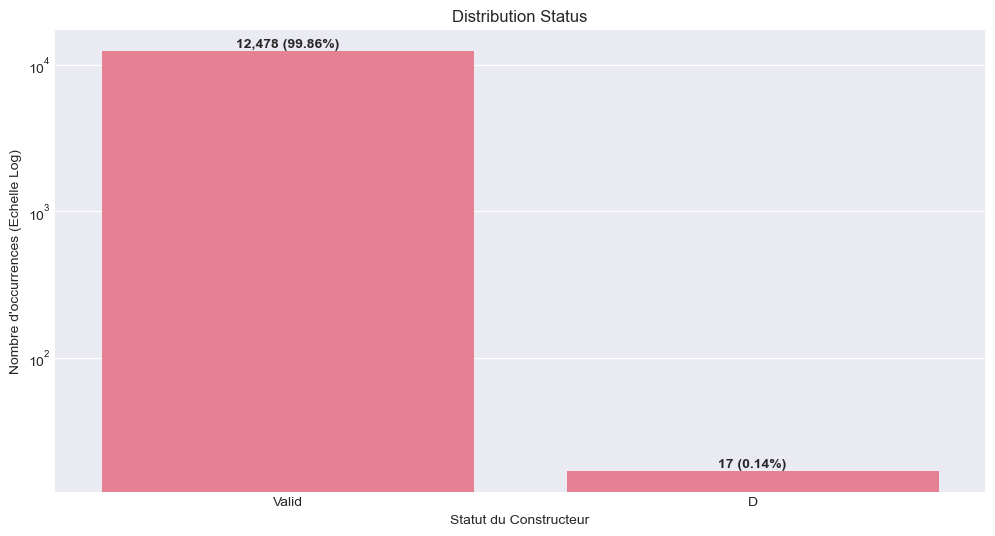

In [41]:
# Inspection des chiffres bruts
print("Distribution de la colonne 'status' :")
print(constructor_results['status'].value_counts(dropna=False))
print("\nPourcentage :")
print(constructor_results['status'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

# Visualisation
plt.figure(figsize=(12, 6))

# Remplissage temporaire des NaN pour visualisation, permet de voir la catégorie "Valid" explicitement sur le graphe
sns.countplot(
    x=constructor_results['status'].fillna('Valid'),
    order=['Valid', 'D'] # On force l'ordre pour la lisibilité
)

plt.title("Distribution Status")
plt.yscale('log') # Echelle log pour visualiser les valeurs minoritaires
plt.ylabel("Nombre d'occurrences (Echelle Log)")
plt.xlabel("Statut du Constructeur")

# Ajout annotations
plt.text(0, 12478, '12,478 (99.86%)', ha='center', va='bottom', fontweight='bold')
plt.text(1, 17, '17 (0.14%)', ha='center', va='bottom', fontweight='bold')

plt.show()

Après cette première étude, nous observons comme attendu un fort déséquilbre entre les nuls (appelés Valid) et les constructeurs contenant un statut "D". 

Ce déséquilibre pourrait être intéressant si nous cherchions à déterminer les écuries championnes d'une saison de F1, seulement ici nous nous concentrons uniquement sur une course. Ainsi, il nous est inutile de savoir quelle voiture a été disqualifiée pour triche (comme McLaren en 2007 avec le scandale Spygate) puisque cela ne révèle en rien ses performances techniques sur le terrain.

Ainsi, nous pouvons donc supprimer cette colonne de notre dataset.

In [43]:
constructor_results.drop(columns=['status'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [47]:
print("Constructor_results :\n",constructor_results.head())

Constructor_results :
    constructorResultsId  raceId  constructorId  points
0                     1      18              1    14.0
1                     2      18              2     8.0
2                     3      18              3     9.0
3                     4      18              4     5.0
4                     5      18              5     2.0


### Nettoyage de constructor_standings 

Pour ce dataset, nous avons décidé de supprimer la colonne positionText. En effet, celle-ci n'est qu'une duplication au format texte de la variable numérique position et n'apporte aucune information supplémentaire exploitable. Sa suppression élimine une redondance inutile et prévient l'introduction de bruit (valeurs non numériques) qui pourrait perturber l'apprentissage de notre modèle.

In [50]:
constructor_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [53]:
print("Constructor_standings :\n",constructor_standings.head())

Constructor_standings :
    constructorStandingsId  raceId  constructorId  points  position  wins
0                       1      18              1    14.0         1     1
1                       2      18              2     8.0         3     0
2                       3      18              3     9.0         2     0
3                       4      18              4     5.0         4     0
4                       5      18              5     2.0         5     0


### Nettoyage Driver_standings :

Même cas que pour Constructor standings avec la colonne positionText.

In [56]:
driver_standings.drop(columns=['positionText'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [59]:
print("Driver_standings :\n",driver_standings.head())

Driver_standings :
    driverStandingsId  raceId  driverId  points  position  wins
0                  1      18         1    10.0         1     1
1                  2      18         2     8.0         2     0
2                  3      18         3     6.0         3     0
3                  4      18         4     5.0         4     0
4                  5      18         5     4.0         5     0


### Analyse de la distribution des nationalités des constructeurs

C:\Users\Eric\AppData\Local\Temp\ipykernel_17376\1777562400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nat_counts.values, y=nat_counts.index, palette='mako')


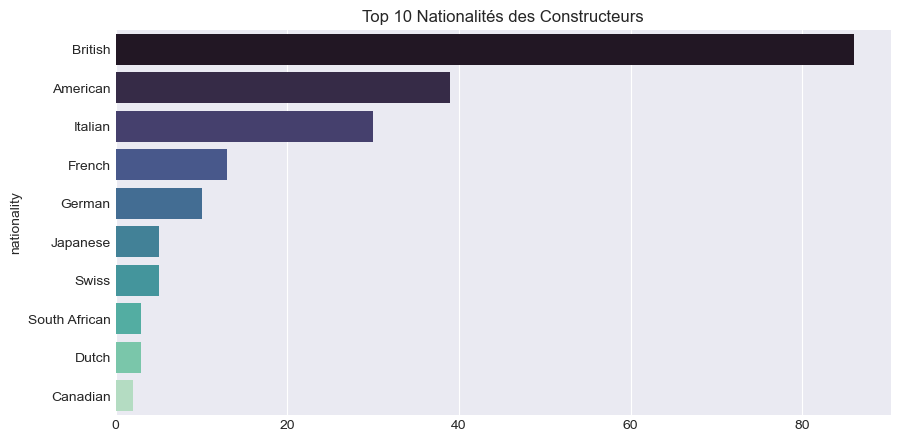

In [62]:
plt.figure(figsize=(10, 5))
nat_counts = constructors['nationality'].value_counts().head(10)
sns.barplot(x=nat_counts.values, y=nat_counts.index, palette='mako')
plt.title("Top 10 Nationalités des Constructeurs")
plt.show()

Nouveau dataset nettoyé :

In [65]:
print("Constructors :\n",constructors.head())

Constructors :
    constructorId constructorRef        name nationality
0              1        mclaren     McLaren     British
1              2     bmw_sauber  BMW Sauber      German
2              3       williams    Williams     British
3              4        renault     Renault      French
4              5     toro_rosso  Toro Rosso     Italian


### Analyse de la distribution des nationalités des pilotes

Dans l'analyse du dataset circuit, nous avions dit qu'il serait intéressant d'analyser la corrélation possibles des victoires à domicile afin d'en conclure d'un potentiel avantage à mettre en avant pour notre modèle. L'analyse de la distribution des nationalités des pilotes pourrait également révèler de potentiels biais historiques (domination de certains pays).

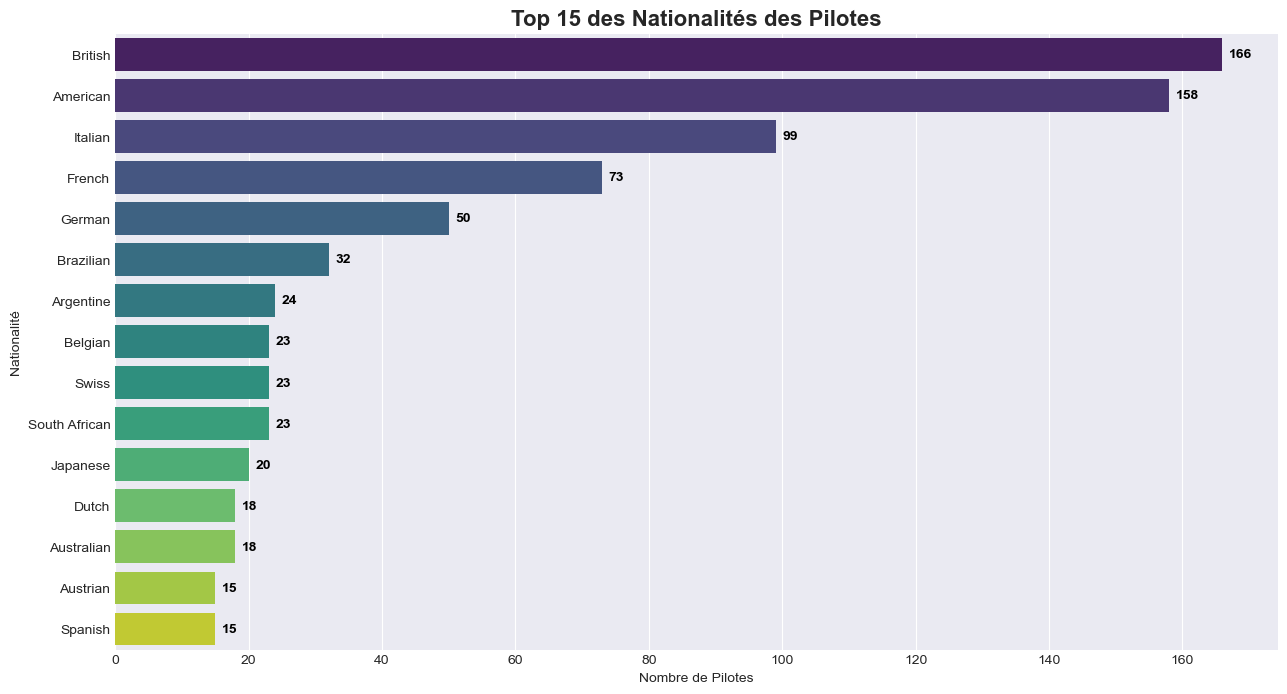

In [68]:
# Calcul des fréquences sur la colonne brute
nationality_counts = drivers['nationality'].value_counts()
top_nationalities = nationality_counts.head(15) # Top 15 pour la lisibilité

# Visualisation
plt.figure(figsize=(15, 8))

sns.barplot(
    x=top_nationalities.values,
    y=top_nationalities.index,
    hue=top_nationalities.index,
    legend=False,
    palette='viridis'
)

plt.title('Top 15 des Nationalités des Pilotes', fontsize=16, fontweight='bold')
plt.xlabel('Nombre de Pilotes')
plt.ylabel('Nationalité')

# Ajout des valeurs au bout des barres
for i, v in enumerate(top_nationalities.values):
    plt.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

Avec ce graphique, on déduit une certaine hégémonie de quelques nations historiques (comme le Royaume-Uni, les États-Unis ou encore l'Italie) face à une longue liste de pays jugés anecdotiques.

Ce fort déséquilibre signifie que la variable nationality contient beaucoup de bruit (haute cardinalité avec peu de fréquence) et devra probablement être simplifiée (par exemple en regroupant les "petites" nations) pour être utile à notre modèle prédictif.

### Nettoyage du fichier drivers

Pour ce dataset, nous avons identifié plusieurs colonnes qui n'ont pas vraiment d'utilité dans la prédiction de la victoire ou non d'une écurie sur un circuit.

##### Distribution en pourcentage de la colonne nombre

In [73]:
print(drivers['number'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

number
NaN     93.36%
40.0     0.23%
99.0     0.23%
21.0     0.23%
2.0      0.23%
10.0     0.23%
22.0     0.23%
9.0      0.23%
88.0     0.23%
28.0     0.23%
6.0      0.23%
4.0      0.23%
18.0     0.12%
30.0     0.12%
94.0     0.12%
53.0     0.12%
31.0     0.12%
44.0     0.12%
16.0     0.12%
35.0     0.12%
55.0     0.12%
63.0     0.12%
23.0     0.12%
51.0     0.12%
89.0     0.12%
47.0     0.12%
24.0     0.12%
81.0     0.12%
98.0     0.12%
26.0     0.12%
12.0     0.12%
13.0     0.12%
14.0     0.12%
7.0      0.12%
19.0     0.12%
5.0      0.12%
8.0      0.12%
27.0     0.12%
11.0     0.12%
33.0     0.12%
3.0      0.12%
25.0     0.12%
77.0     0.12%
17.0     0.12%
20.0     0.12%
45.0     0.12%
38.0     0.12%
Name: proportion, dtype: object


La colonne nombre contient 802 valeurs nulles sur 859 (93.36% de vide). Il nous faut donc, si nous la conservons, penser à la nettoyer.
Historiquement, les numéros des pilotes de F1 changeaient chaque année ou n'existaient pas. Aujourd'hui, ils ne sont là que pour le marketing (le numéro 44 est par exemple celui d'Hamilton). Il n'existe donc aucune corrélation physique entre le numéro du pilote et sa vitesse et cela apporte même une redondance si on l'utilise pour son identification. Nous pouvons donc la supprimer.

In [76]:
drivers.drop(columns=['number'], inplace=True, errors='ignore')

#### Distribution en pourcentage de la colonne code

In [79]:
print(drivers['code'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

code
NaN    88.13%
VER     0.23%
BIA     0.23%
MSC     0.23%
MAG     0.23%
        ...  
MON     0.12%
YAM     0.12%
WIN     0.12%
SPE     0.12%
BEA     0.12%
Name: proportion, Length: 97, dtype: object


La colonne code, comme pour la colonne nombre contient une majorité de valeurs nulles (88.13%).
Cette variable est elle aussi plutôt inutile puisqu'elle n'est que l'abréviation du nom de famille du pilote. Nous pouvons donc la supprimer.

In [82]:
drivers.drop(columns=['code'], inplace=True, errors='ignore')

#### Suppression de driverRef

Cette colonne est une simple répétition des noms de famille, cela est inutile pour notre modèle qui utilisera les driverId pour identifier ces derniers. Nous pouvons donc l'éliminer.

In [85]:
drivers.drop(columns=['driverRef'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [88]:
print("Drivers :\n",drivers.head())

Drivers :
    driverId  forename     surname         dob nationality
0         1     Lewis    Hamilton  1985-01-07     British
1         2      Nick    Heidfeld  1977-05-10      German
2         3      Nico     Rosberg  1985-06-27      German
3         4  Fernando      Alonso  1981-07-29     Spanish
4         5    Heikki  Kovalainen  1981-10-19     Finnish


### Nettoyage de Lap_Times

In [91]:
lap_times.drop(columns=['time'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [94]:
print("Lap_times :\n",lap_times.head())

Lap_times :
    raceId  driverId  lap  position  milliseconds
0     841        20    1         1         98109
1     841        20    2         1         93006
2     841        20    3         1         92713
3     841        20    4         1         92803
4     841        20    5         1         92342


### Analyse distribution des pit_stops et nettoyage du dataframe

In [97]:
pit_stops.drop(columns=['time'], inplace=True, errors='ignore')
pit_stops.drop(columns=['duration'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [100]:
print("Pit_stops :\n",pit_stops.head())

Pit_stops :
    raceId  driverId  stop  lap  milliseconds
0     841       153     1    1         26898
1     841        30     1    1         25021
2     841        17     1   11         23426
3     841         4     1   12         23251
4     841        13     1   13         23842


### Nettoyage de Qualifying

In [103]:
qualifying.drop(columns=['qualifyId'], inplace=True, errors='ignore')
qualifying.drop(columns=['number'], inplace=True, errors='ignore')
qualifying.drop(columns=['q1'], inplace=True, errors='ignore')
qualifying.drop(columns=['q2'], inplace=True, errors='ignore')
qualifying.drop(columns=['q3'], inplace=True, errors='ignore')

Nouveau dataset nettoyé :

In [106]:
print("Qualifying :\n",qualifying.head())

Qualifying :
    raceId  driverId  constructorId  position
0      18         1              1         1
1      18         9              2         2
2      18         5              1         3
3      18        13              6         4
4      18         2              2         5


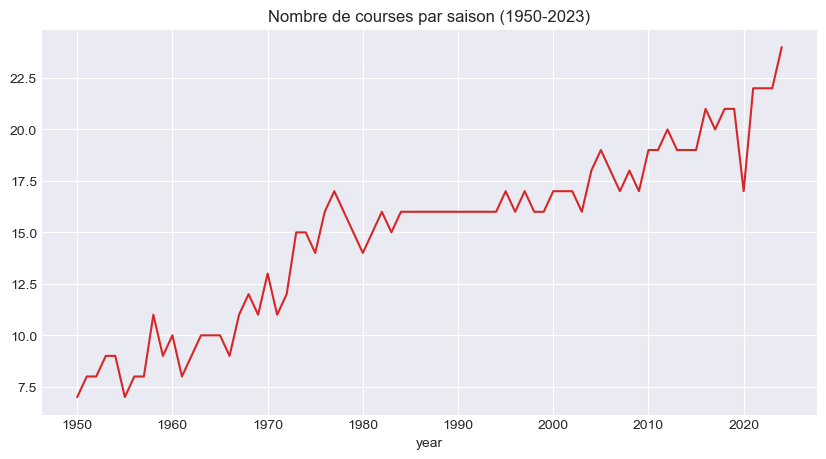

C:\Users\Eric\AppData\Local\Temp\ipykernel_17376\2755583473.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_grid.index, y=win_grid.values, palette='viridis')


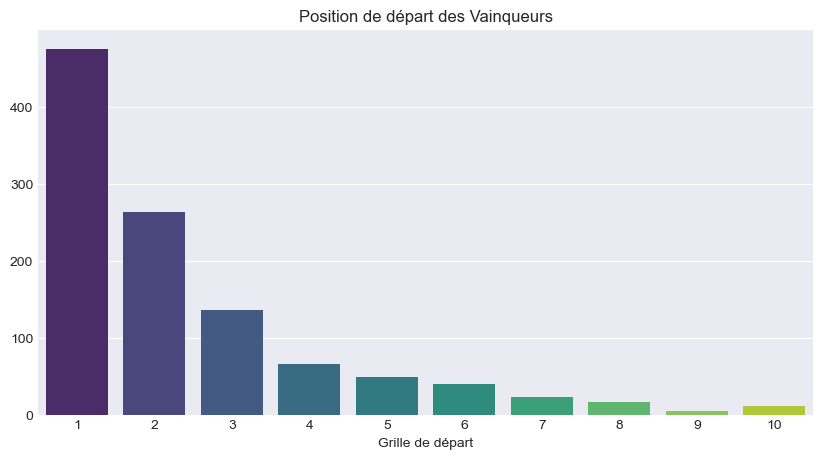

In [109]:
# 2. Races : Densification du calendrier
plt.figure(figsize=(10, 5))
races_year = races['year'].value_counts().sort_index()
sns.lineplot(x=races_year.index, y=races_year.values, color='tab:red')
plt.title("Nombre de courses par saison (1950-2023)")
plt.show()

# 3. Results : L'importance de la Pole
plt.figure(figsize=(10, 5))
winners = results[results['positionOrder'] == 1]
win_grid = winners['grid'].value_counts().sort_index().head(10)
sns.barplot(x=win_grid.index, y=win_grid.values, palette='viridis')
plt.title("Position de départ des Vainqueurs")
plt.xlabel("Grille de départ")
plt.show()

Nouveau dataset nettoyé

In [112]:
print("Races :\n",races.head())

Races :
    raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time fp1_date fp1_time fp2_date fp2_time fp3_date fp3_time quali_date  \
0  06:00:00      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
1  09:00:00      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
2  07:00:00      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
3  12:00:00      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
4  12:00:00      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

  quali_time sprint_date sprint_time  
0        NaN         NaN         NaN  

Nouveau dataset nettoyé

In [117]:
print("Results :\n",results.head())

Results :
    resultId  raceId  driverId  constructorId  number  grid  position  \
0         1      18         1              1    22.0     1       1.0   
1         2      18         2              2     3.0     5       2.0   
2         3      18         3              3     7.0     7       3.0   
3         4      18         4              4     5.0    11       4.0   
4         5      18         5              1    23.0     3       5.0   

  positionText  positionOrder  points  laps         time  milliseconds  \
0            1              1    10.0    58  1:34:50.616     5690616.0   
1            2              2     8.0    58       +5.478     5696094.0   
2            3              3     6.0    58       +8.163     5698779.0   
3            4              4     5.0    58      +17.181     5707797.0   
4            5              5     4.0    58      +18.014     5708630.0   

   fastestLap  rank fastestLapTime  fastestLapSpeed  statusId  
0        39.0   2.0       1:27.452          218

### Fiabilité : Analyse des Abandons (Status)

Les abandons ("Engine", "Gearbox") sont fréquents, surtout dans les années passées. Il pourrait être importants dans la prédiction d'un vainqueur (accidents causés par le conducteur, problèmes liés au véhicules) ou non (accidents liés à un autre usager). Certains circuits sont même considérés comme des "tueurs de voitures"

<>:7: SyntaxWarning: invalid escape sequence '\+'
<>:7: SyntaxWarning: invalid escape sequence '\+'
C:\Users\Eric\AppData\Local\Temp\ipykernel_17376\3755649722.py:7: SyntaxWarning: invalid escape sequence '\+'
  dnf_data = df_status[~df_status['status'].str.contains('Finished|\+', regex=True)]


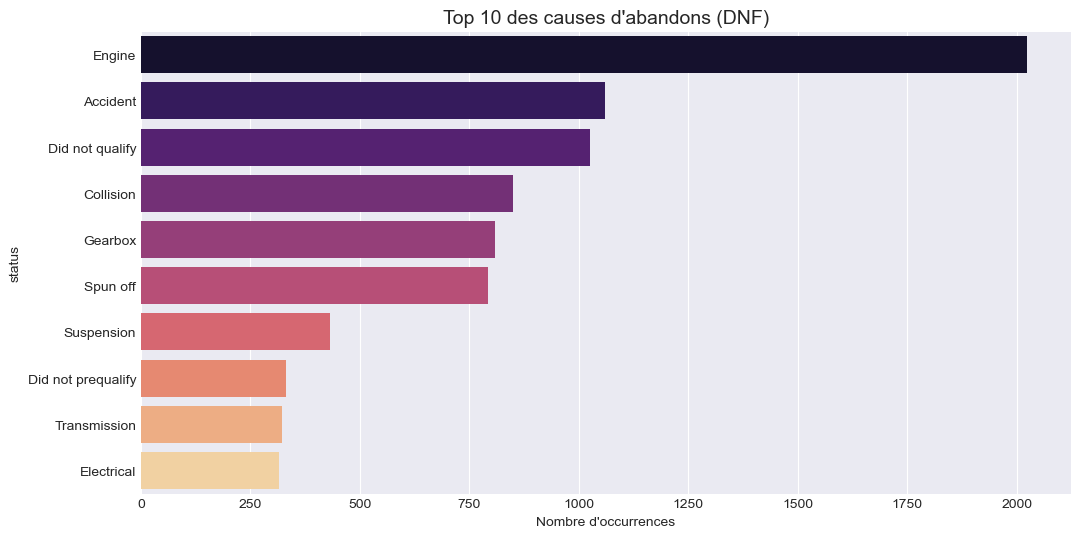

In [120]:
def analyze_reliability():
    
    # Fusion avec la table status (Assure-toi que results_df et status_df sont bien chargés avant)
    df_status = results_df.merge(status_df, on='statusId')
    
    # Filtrer ce qui n'est pas "Finished" ou "+1 Lap" (les abandons réels)
    dnf_data = df_status[~df_status['status'].str.contains('Finished|\+', regex=True)]
    
    top_causes = dnf_data['status'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    
    sns.barplot(
        y=top_causes.index, 
        x=top_causes.values, 
        hue=top_causes.index,  # On lie la couleur à la catégorie (Y)
        legend=False,          
        orient='h', 
        palette='magma'
    )
    
    plt.title("Top 10 des causes d'abandons (DNF)", fontsize=14)
    plt.xlabel("Nombre d'occurrences")
    plt.show()

analyze_reliability()

L'histogramme révèle une hiérarchie claire des défaillances en F1 : les problèmes mécaniques (Moteur en tête avec plus de 2000 cas) restent historiquement la cause majeure d'abandon, doublant presque la seconde cause.

Cependant, la violence de la course est omniprésente, le cumul des incidents de pilotage (Accident, Collision, Spun off) représentant un volume d'abandons supérieur à celui des moteurs seuls, soulignant que la fiabilité technique ne suffit pas pour finir une course.

Ainsi, il pourrait être intéressant de créer une feature constructor_reliability : afin d'analyser le taux de courses terminées par l'écurie sur la saison en cours.

### Datasets inutilisables pour notre modèle de prédiction

Enfin, avant de passer au merged, nous avons encore besoin de nettoyer quelques jeux de données qui sont complètement inutilisables pour notre étude. C'est le cas de seasons.csv qui est un fichier purement redondant puisqu'il n'indique que l'année est déjà donnée dans races.csv. Le dataset sprint_results.csv est également inutilisable car l'épreuve des sprints n'existe que depuis 2021. Il y a donc un fort risque de déstabilisation de notre modèle pour rien. L'impact réel des sprints (points et grille) est de toute façon déjà capturé dans nos fichiers principaux (results et qualifying). 

Ainsi, la suppression de ces 2 fichiers élimine du bruit massif sans perdre une seule information prédictive.

In [124]:
try:
    del seasons
    del sprint_results
    print("Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.")
except NameError:
    print("Info : Ces fichiers étaient déjà supprimés ou non chargés.")

Succès : Les fichiers 'seasons' et 'sprint_results' ont été supprimés.


# Analyse Multivariée

## PRÉPARATION DES DONNÉES POUR L'ANALYSE

On commence par fusionner les tables critiques pour notre analyse, puis on relie les résultats aux courses (pour la date), aux écuries et aux circuits

In [128]:
df_full = results_df.merge(races_df[['raceId', 'year', 'name', 'circuitId', 'date']], on='raceId', suffixes=('', '_race'))
df_full = df_full.merge(constructors_df[['constructorId', 'name']], on='constructorId', suffixes=('', '_team'))
df_full = df_full.merge(circuits_df[['circuitId', 'country', 'alt']], on='circuitId')

# Conversion de la position finale en numérique (gestion des abandons qui ne sont pas des chiffres)
# Dans le dataset F1, positionOrder est propre (numérique), positionText contient 'R', 'D', etc.
df_winner = df_full[df_full['positionOrder'] == 1].copy()

## Distribution des Victoires par Ecurie

Notre objectif est ici de comprendre le déséquilibre extrême de notre variable cible. Nous allons commencer par visualiser les 15 écuries ayant le plus de victoires, puis nous allons comparer les 5 ayant le taux de victoire le plus élevé avec les autres. Ensuite nous étudions temporellement les victoires des écuries top5 avant d'observer un déséquilibre binaire entre les gagnants et les perdants.

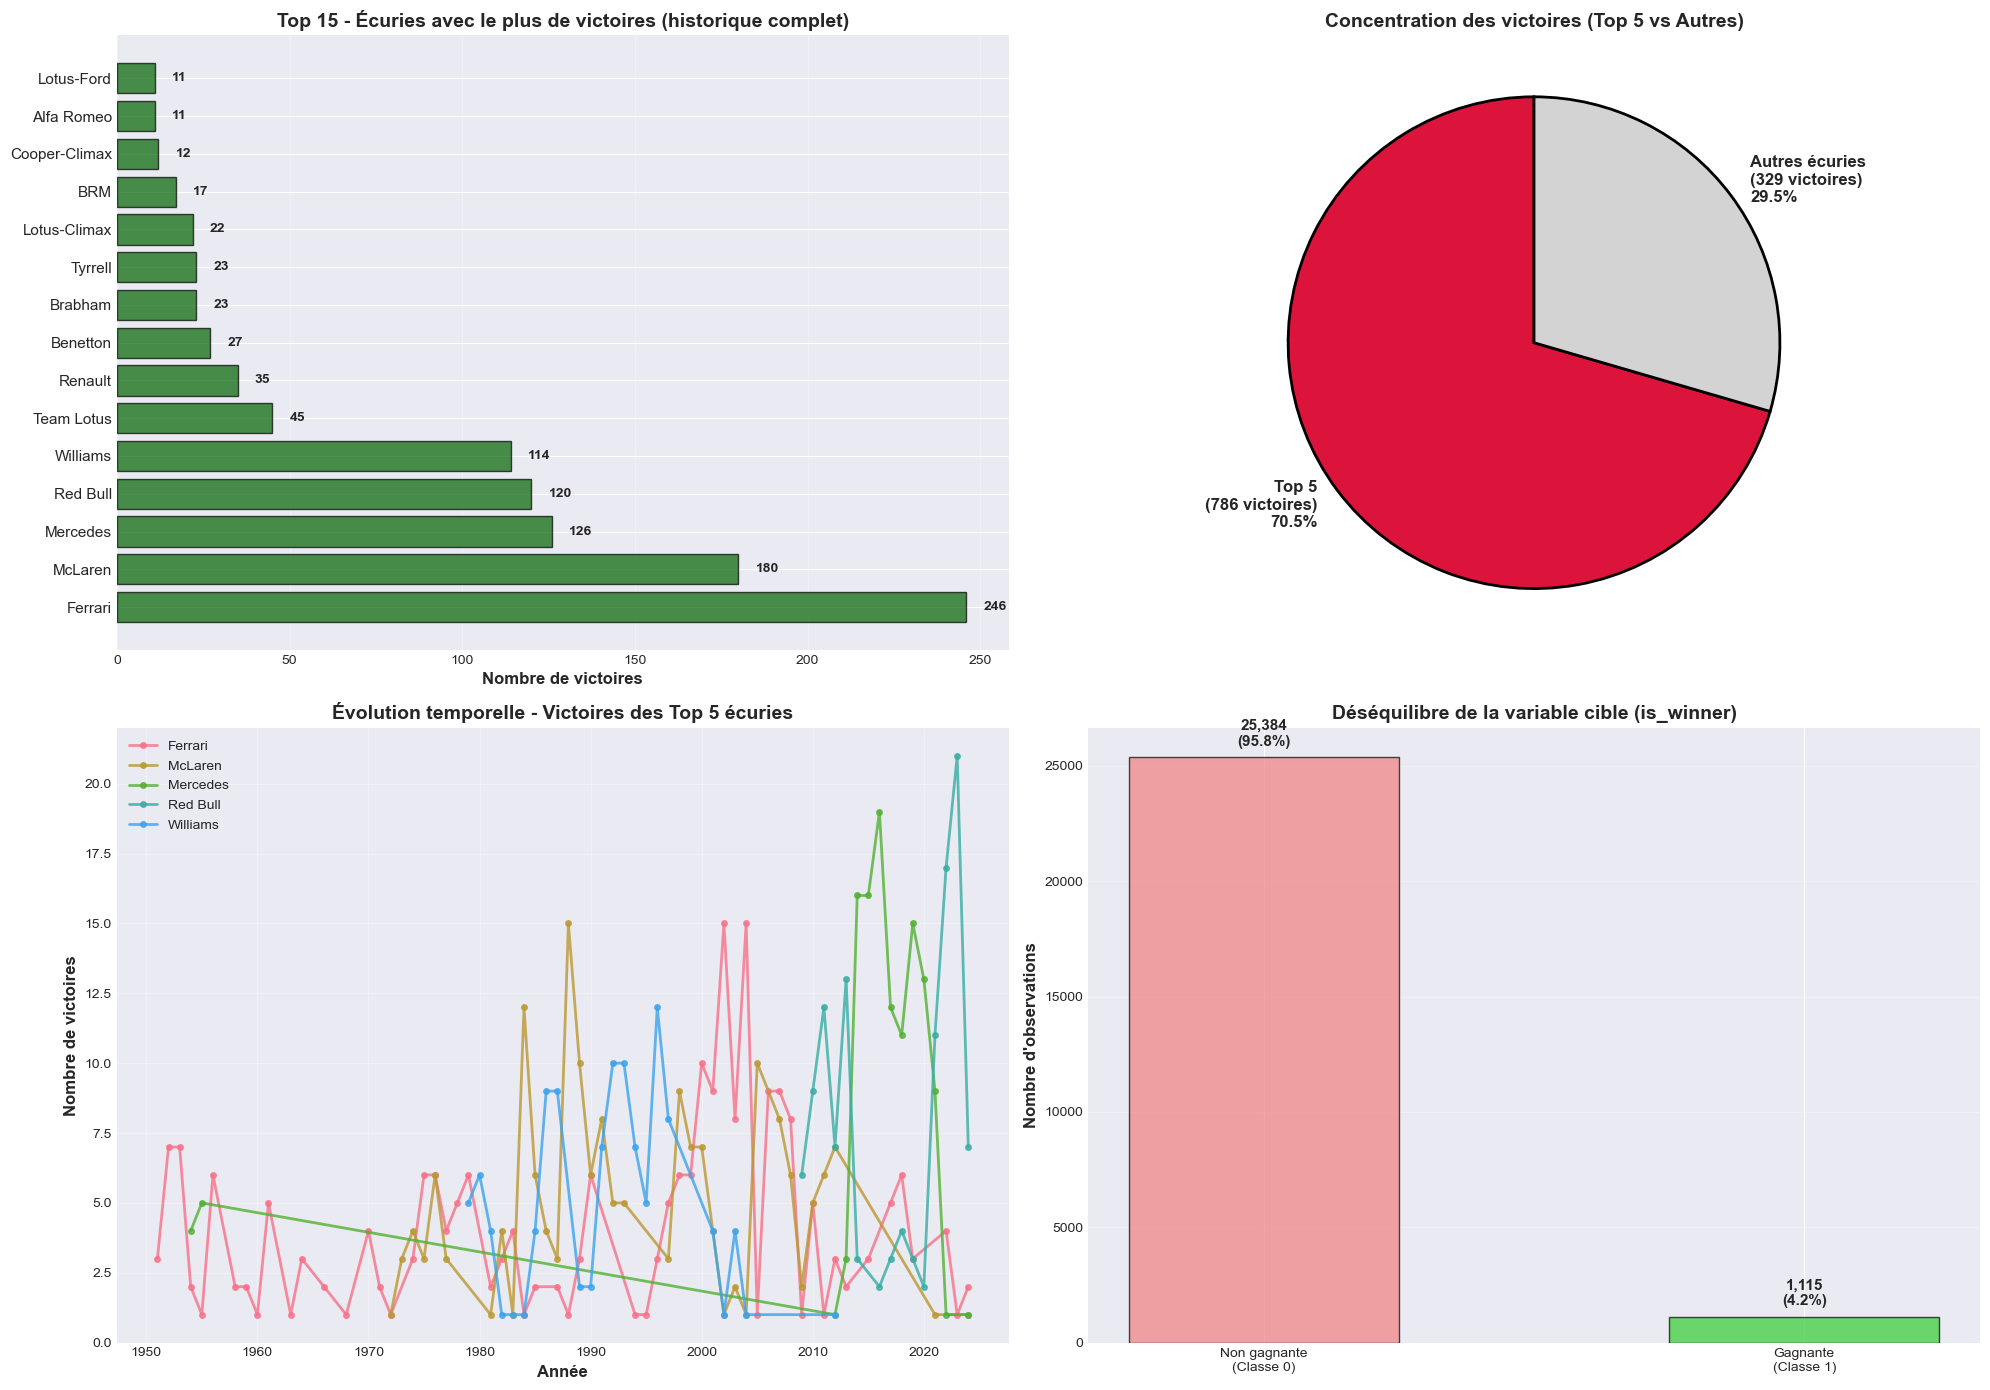


✓ Ratio de déséquilibre : 22.8:1 (non-gagnant:gagnant)
✓ Top 5 représente 70.5% des victoires


In [131]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Identifier les victoires (position = 1)
winners = results_df[results_df['positionOrder'] == 1].copy()
winners_with_constructor = winners.merge(constructors_df, on='constructorId')
winners_with_race = winners_with_constructor.merge(races_df[['raceId', 'year']], on='raceId')

# 2.1 - Top 15 écuries par nombre de victoires (toute l'histoire)
wins_by_constructor = winners_with_constructor['name'].value_counts().head(15)

axes[0, 0].barh(range(len(wins_by_constructor)), wins_by_constructor.values, 
                color='darkgreen', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(wins_by_constructor)))
axes[0, 0].set_yticklabels(wins_by_constructor.index, fontsize=11)
axes[0, 0].set_xlabel('Nombre de victoires', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Top 15 - Écuries avec le plus de victoires (historique complet)', 
                     fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

for i, val in enumerate(wins_by_constructor.values):
    axes[0, 0].text(val + 5, i, f'{val}', va='center', fontweight='bold', fontsize=10)

# 2.2 - Déséquilibre : % de victoires pour Top 5 vs Autres
total_wins = len(winners)
top5_wins = wins_by_constructor.head(5).sum()
other_wins = total_wins - top5_wins

pie_data = [top5_wins, other_wins]
pie_labels = [f'Top 5\n({top5_wins} victoires)\n{top5_wins/total_wins*100:.1f}%', 
              f'Autres écuries\n({other_wins} victoires)\n{other_wins/total_wins*100:.1f}%']
colors_pie = ['crimson', 'lightgray']

axes[0, 1].pie(pie_data, labels=pie_labels, autopct='', colors=colors_pie, 
               startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
               wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[0, 1].set_title('Concentration des victoires (Top 5 vs Autres)', 
                     fontsize=14, fontweight='bold')

# 2.3 - Évolution des victoires par ère pour Top 5
top5_constructors = wins_by_constructor.head(5).index.tolist()

for constructor in top5_constructors:
    constructor_wins = winners_with_race[winners_with_race['name'] == constructor]
    wins_by_year = constructor_wins.groupby('year').size()
    axes[1, 0].plot(wins_by_year.index, wins_by_year.values, marker='o', 
                    label=constructor, linewidth=2, markersize=4, alpha=0.8)

axes[1, 0].set_xlabel('Année', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Nombre de victoires', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Évolution temporelle - Victoires des Top 5 écuries', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 2.4 - Distribution de la variable cible (binaire)
# Pour chaque course, combien d'écuries sont candidates (participantes) vs gagnante
results_with_constructor = results_df.merge(constructors_df[['constructorId', 'name']], on='constructorId')
results_with_constructor['is_winner'] = (results_with_constructor['positionOrder'] == 1).astype(int)

class_distribution = results_with_constructor['is_winner'].value_counts()
class_labels = ['Non gagnante\n(Classe 0)', 'Gagnante\n(Classe 1)']

axes[1, 1].bar(class_labels, class_distribution.values, 
               color=['lightcoral', 'limegreen'], alpha=0.7, edgecolor='black', width=0.5)
axes[1, 1].set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Déséquilibre de la variable cible (is_winner)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, val in enumerate(class_distribution.values):
    axes[1, 1].text(i, val + 500, f'{val:,}\n({val/class_distribution.sum()*100:.1f}%)', 
                    ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('viz2_distribution_victoires.png', dpi=300, bbox_inches='tight')
plt.show()

imbalance_ratio = class_distribution[0] / class_distribution[1]
print(f"\n✓ Ratio de déséquilibre : {imbalance_ratio:.1f}:1 (non-gagnant:gagnant)")
print(f"✓ Top 5 représente {top5_wins/total_wins*100:.1f}% des victoires")

### Ce que nous en concluons pour l'étape de preprocessing :

Il nous faut gérer ce déséquilibre, via la méthode SMOTE, class_weight ou undersampling.
On peut peut-être proposer des modèles séparés par ère ? Ou nous limiter à certaines écuries ? Il nous faut relier les écuries fusionnées avec celles compétants actuellement et éliminer les anciennes qui ne concourrent plus et n'ont pas été fusionnées.

## Timeline de Complétude des Données

Notre objectif est ici d'identifier la période temporelle avec les données les plus fiables entre1950 et 2024. Chaque année, chaque décennie les saisons, le nombre de courses et les conditions sont amenées à changer. Est-ce de beaucoup et est-ce impactant ? Ici nous allons observer :

- Évolution du nombre de courses par saison
- Nombre d'écuries participantes par année
- Disponibilité des données de Qualifying par année
- Disponibilité des données de Pit Stops (à partir de quelle année)

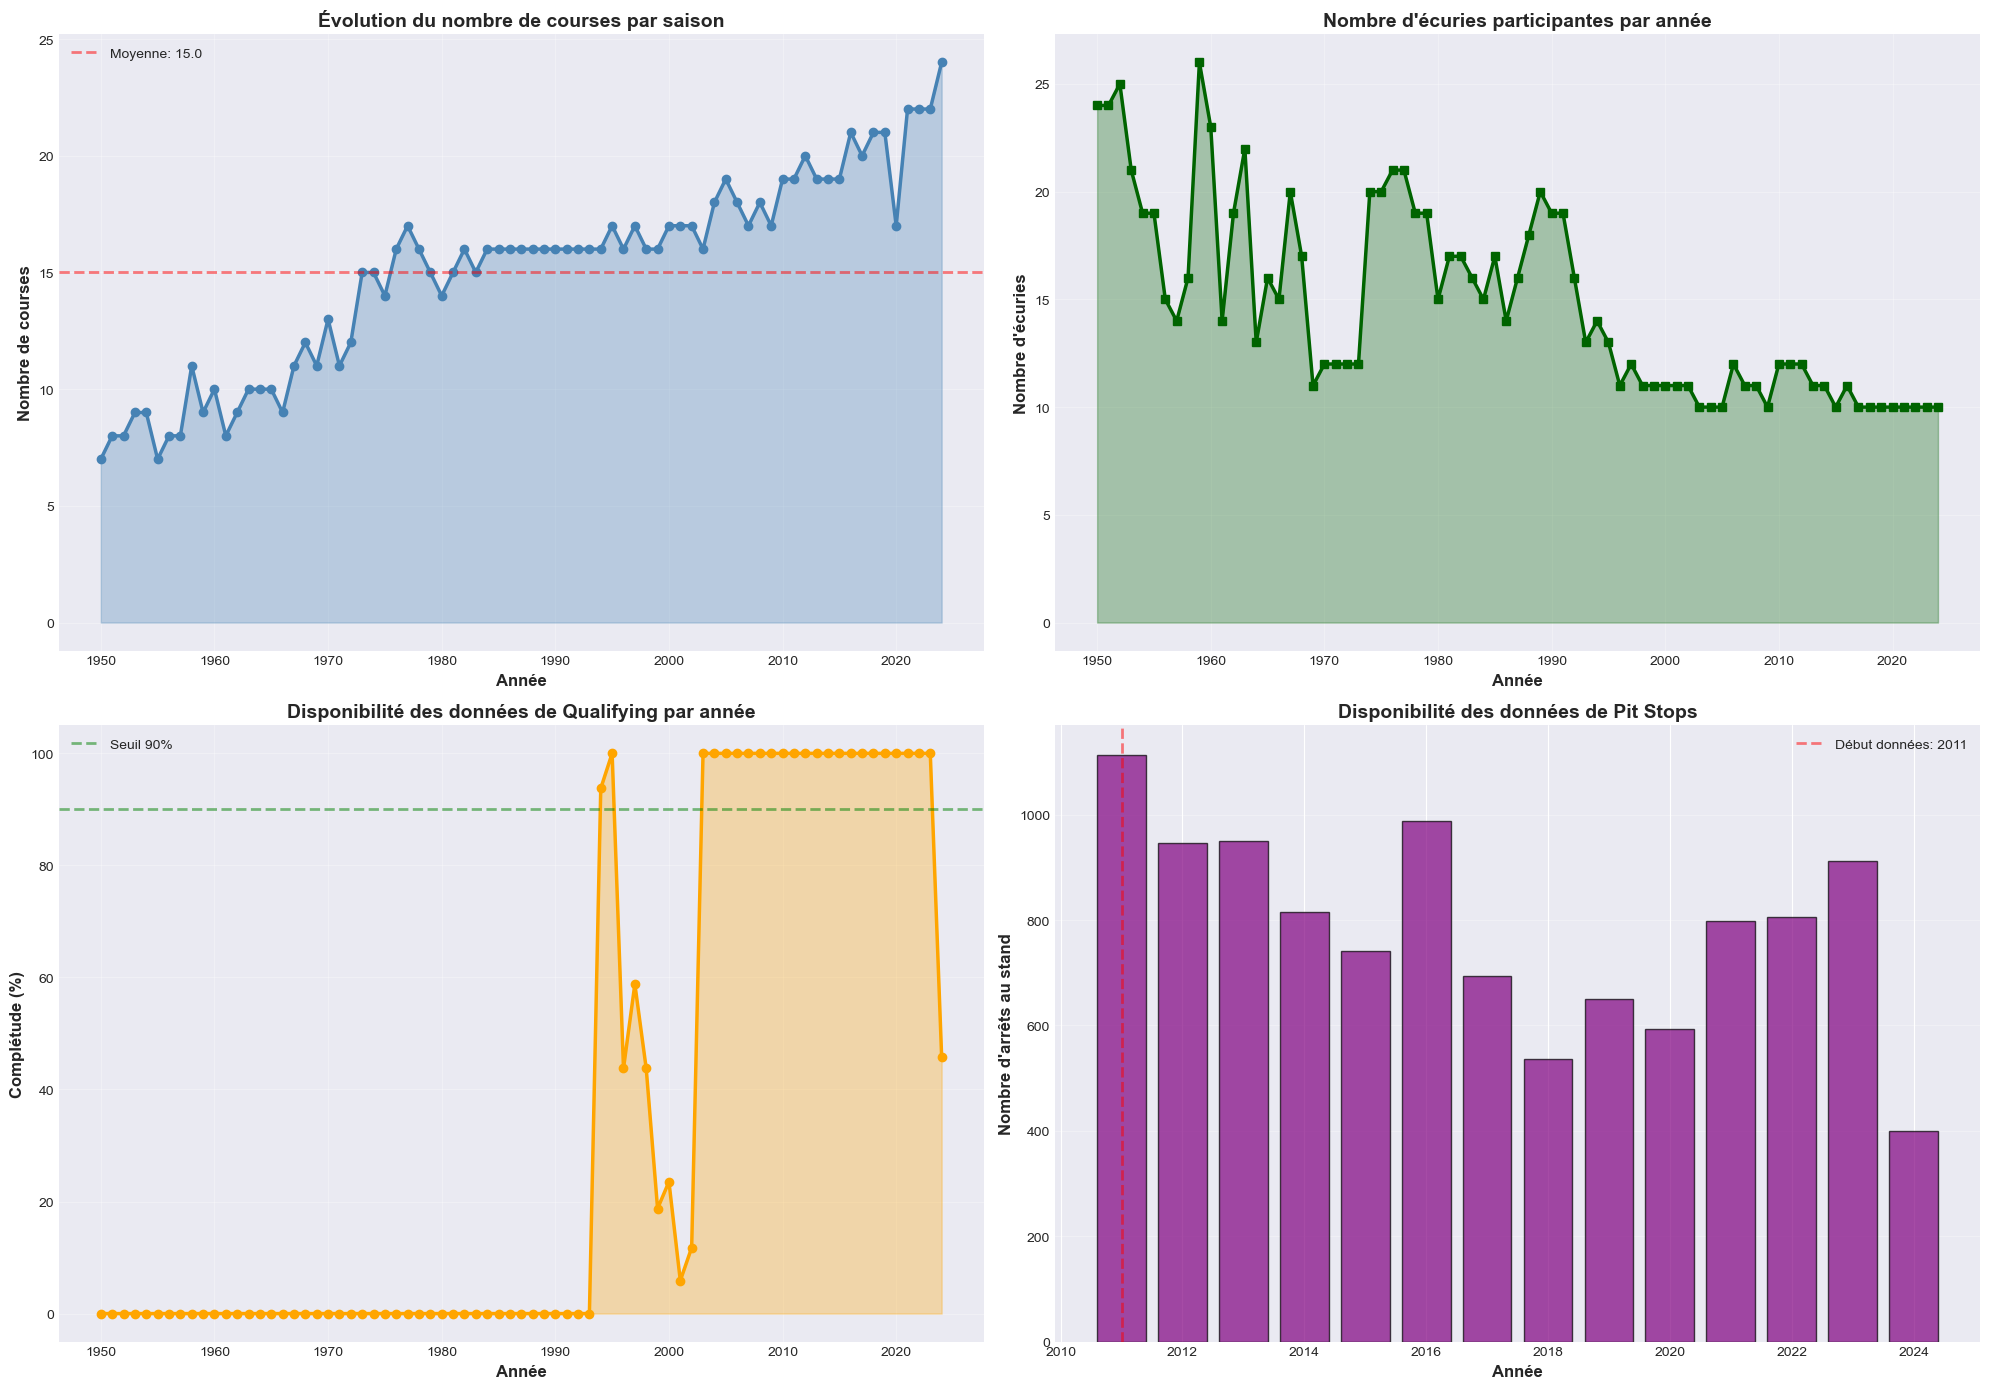


✓ Période couverte : 1950 - 2024
✓ Qualifying complétude moyenne : 33.9%


In [134]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# 3.1 - Nombre de courses par année
races_per_year = races_df.groupby('year').size()

axes[0, 0].plot(races_per_year.index, races_per_year.values, marker='o', 
                color='steelblue', linewidth=2.5, markersize=6)
axes[0, 0].fill_between(races_per_year.index, races_per_year.values, alpha=0.3, color='steelblue')
axes[0, 0].set_xlabel('Année', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Nombre de courses', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Évolution du nombre de courses par saison', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=races_per_year.mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'Moyenne: {races_per_year.mean():.1f}')
axes[0, 0].legend()

# 3.2 - Nombre d'écuries uniques par année
results_with_year = results_df.merge(races_df[['raceId', 'year']], on='raceId')
constructors_per_year = results_with_year.groupby('year')['constructorId'].nunique()

axes[0, 1].plot(constructors_per_year.index, constructors_per_year.values, marker='s', 
                color='darkgreen', linewidth=2.5, markersize=6)
axes[0, 1].fill_between(constructors_per_year.index, constructors_per_year.values, 
                        alpha=0.3, color='darkgreen')
axes[0, 1].set_xlabel('Année', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Nombre d\'écuries', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Nombre d\'écuries participantes par année', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3.3 - Disponibilité des données de qualifying par année
quali_with_year = qualifying_df.merge(races_df[['raceId', 'year']], on='raceId')
quali_completeness = []

for year in sorted(races_df['year'].unique()):
    races_year = races_df[races_df['year'] == year]['raceId'].unique()
    quali_year = quali_with_year[quali_with_year['year'] == year]['raceId'].nunique()
    completeness = (quali_year / len(races_year)) * 100 if len(races_year) > 0 else 0
    quali_completeness.append({'year': year, 'completeness': completeness})

quali_comp_df = pd.DataFrame(quali_completeness)

axes[1, 0].plot(quali_comp_df['year'], quali_comp_df['completeness'], marker='o', 
                color='orange', linewidth=2.5, markersize=6)
axes[1, 0].fill_between(quali_comp_df['year'], quali_comp_df['completeness'], 
                        alpha=0.3, color='orange')
axes[1, 0].set_xlabel('Année', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Complétude (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Disponibilité des données de Qualifying par année', 
                     fontsize=14, fontweight='bold')
axes[1, 0].axhline(y=90, color='green', linestyle='--', linewidth=2, 
                   alpha=0.5, label='Seuil 90%')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 3.4 - Disponibilité des pit stops par année
if len(pit_stops_df) > 0:
    pitstops_with_year = pit_stops_df.merge(races_df[['raceId', 'year']], on='raceId')
    pitstops_per_year = pitstops_with_year.groupby('year').size()
    
    axes[1, 1].bar(pitstops_per_year.index, pitstops_per_year.values, 
                   color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Année', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Nombre d\'arrêts au stand', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Disponibilité des données de Pit Stops', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    first_year = pitstops_per_year.index.min()
    axes[1, 1].axvline(x=first_year, color='red', linestyle='--', linewidth=2, 
                       alpha=0.5, label=f'Début données: {first_year}')
    axes[1, 1].legend()

plt.tight_layout()
plt.savefig('viz3_completude_temporelle.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Période couverte : {races_df['year'].min()} - {races_df['year'].max()}")
print(f"✓ Qualifying complétude moyenne : {quali_comp_df['completeness'].mean():.1f}%")

### Ce que nous en concluons pour l'étape de preprocessing :

Des features qui peuvent être importants dans notre prediction ne sont pas toujours disponibles en fonction de l'ère (qualifying notamment). Il serait peut-être plus pertinent de se concentrer sur une fenêtre temporelle plus réduite et plus récente pour entraîner notre modèle.

## Feature Importance Préliminaire

Cette partie nous permet, grâce à un rapide Random Forest, de visualiser et de découvrir quelles variables brutes sont les plus prédictives et donc les plus utiles à l'entraînement de notre model.

Ici, nous allons observer :

- Barplot des importances de 6 features brutes :
  - Position grille (grid position)
  - Temps de qualifications
  - Victoires récentes de l'écurie (10 dernières courses)
  - Circuit (encodé)
  - Écurie (encodée)
  - Année (normalisée)
- Contribution cumulée des features (courbe)
- Performance du modèle Random Forest préliminaire

  → 10041 observations avec features complètes sur 26499
  → Entraînement du Random Forest...


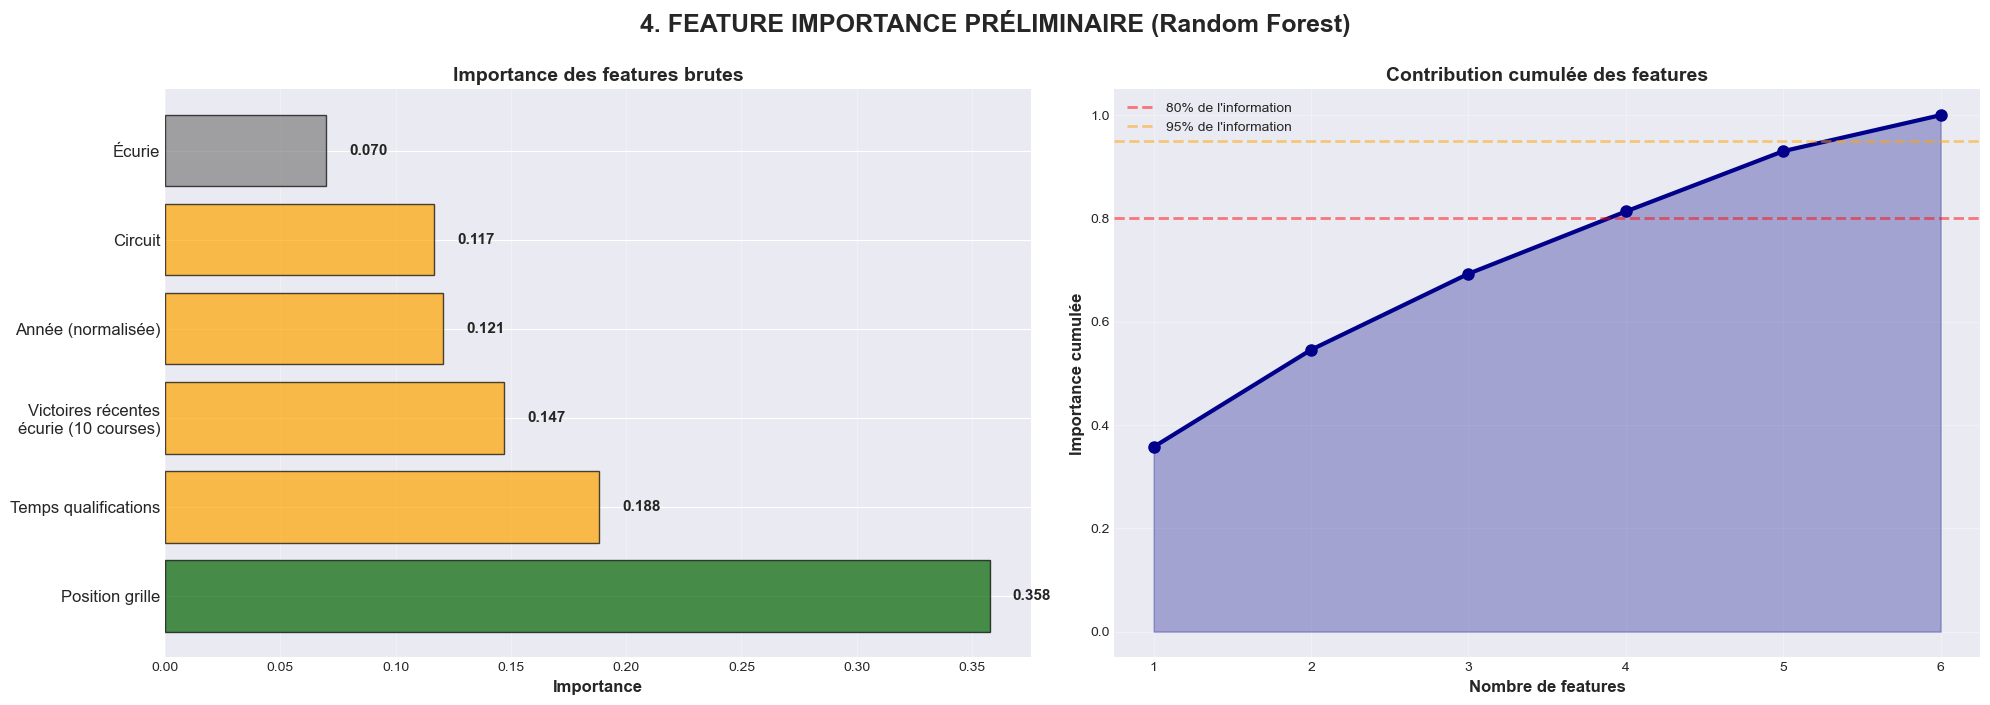


✓ Performance du modèle préliminaire :
  - Accuracy train : 0.981
  - Accuracy test : 0.949

✓ Top 3 features les plus importantes :
  1. Position grille                → 0.358
  2. Temps qualifications           → 0.188
  3. Victoires récentes
écurie (10 courses) → 0.147


In [137]:
# Merger les données nécessaires
df_model = results_df.merge(races_df[['raceId', 'year', 'circuitId']], on='raceId')
df_model = df_model.merge(qualifying_df[['raceId', 'driverId', 'q1', 'q2', 'q3']], 
                          on=['raceId', 'driverId'], how='left')
df_model = df_model.merge(constructors_df[['constructorId', 'name']], on='constructorId')

# Créer la variable cible
df_model['is_winner'] = (df_model['positionOrder'] == 1).astype(int)

# Feature 1 : grid position
df_model['grid_clean'] = pd.to_numeric(df_model['grid'], errors='coerce')

# Feature 2 : qualifying time (prendre le meilleur temps)
def extract_quali_ms(row):
    for q in ['q3', 'q2', 'q1']:
        if pd.notna(row[q]) and row[q] != '\\N':
            try:
                time_str = row[q]
                if ':' in time_str:
                    parts = time_str.split(':')
                    minutes = int(parts[0])
                    seconds = float(parts[1])
                    return (minutes * 60 + seconds) * 1000
            except:
                pass
    return np.nan

df_model['quali_time_ms'] = df_model.apply(extract_quali_ms, axis=1)

# Feature 3 : historique victoires récentes de l'écurie (sur 10 dernières courses)
df_model = df_model.sort_values(['constructorId', 'raceId'])
df_model['constructor_prev_wins'] = df_model.groupby('constructorId')['is_winner'].transform(
    lambda x: x.shift(1).rolling(window=10, min_periods=1).sum()
)

# Feature 4 : circuit_id encodé
le_circuit = LabelEncoder()
df_model['circuit_encoded'] = le_circuit.fit_transform(df_model['circuitId'])

# Feature 5 : constructor_id encodé
le_constructor = LabelEncoder()
df_model['constructor_encoded'] = le_constructor.fit_transform(df_model['constructorId'])

# Feature 6 : année normalisée
df_model['year_norm'] = (df_model['year'] - df_model['year'].min()) / (df_model['year'].max() - df_model['year'].min())

# Sélectionner uniquement les lignes avec données complètes
features = ['grid_clean', 'quali_time_ms', 'constructor_prev_wins', 
            'circuit_encoded', 'constructor_encoded', 'year_norm']

df_clean = df_model[features + ['is_winner']].dropna()

print(f"  → {len(df_clean)} observations avec features complètes sur {len(df_model)}")

# Entraînement Random Forest rapide
X = df_clean[features]
y = df_clean['is_winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("  → Entraînement du Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Calcul des importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('4. FEATURE IMPORTANCE PRÉLIMINAIRE (Random Forest)', 
             fontsize=18, fontweight='bold', y=1.00)

# 4.1 - Barplot des importances
feature_names_fr = {
    'grid_clean': 'Position grille',
    'quali_time_ms': 'Temps qualifications',
    'constructor_prev_wins': 'Victoires récentes\nécurie (10 courses)',
    'circuit_encoded': 'Circuit',
    'constructor_encoded': 'Écurie',
    'year_norm': 'Année (normalisée)'
}

feature_importance_df['feature_fr'] = feature_importance_df['feature'].map(feature_names_fr)

colors_importance = ['darkgreen' if x > 0.2 else 'orange' if x > 0.1 else 'gray' 
                     for x in feature_importance_df['importance']]

axes[0].barh(range(len(feature_importance_df)), feature_importance_df['importance'], 
             color=colors_importance, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(feature_importance_df)))
axes[0].set_yticklabels(feature_importance_df['feature_fr'], fontsize=12)
axes[0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Importance des features brutes', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(feature_importance_df.iterrows()):
    axes[0].text(row['importance'] + 0.01, i, f"{row['importance']:.3f}", 
                 va='center', fontweight='bold', fontsize=11)

# 4.2 - Contribution cumulée
cumulative = feature_importance_df['importance'].cumsum()
axes[1].plot(range(1, len(cumulative)+1), cumulative, marker='o', 
             color='darkblue', linewidth=3, markersize=8)
axes[1].fill_between(range(1, len(cumulative)+1), cumulative, alpha=0.3, color='darkblue')
axes[1].set_xlabel('Nombre de features', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Importance cumulée', fontsize=12, fontweight='bold')
axes[1].set_title('Contribution cumulée des features', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, len(cumulative)+1))
axes[1].set_xticklabels(range(1, len(cumulative)+1))
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, 
                alpha=0.5, label='80% de l\'information')
axes[1].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, 
                alpha=0.5, label='95% de l\'information')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('viz4_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Performance du modèle
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\n✓ Performance du modèle préliminaire :")
print(f"  - Accuracy train : {train_score:.3f}")
print(f"  - Accuracy test : {test_score:.3f}")
print(f"\n✓ Top 3 features les plus importantes :")
for i, row in feature_importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature_fr']:30} → {row['importance']:.3f}")

### Ce que nous en concluons pour l'étape de preprocessing :

Il est probable que grid position et qualifying time soient les variables dominantes (>50% de l'importance), elles sont donc celles à qui nous devons accorder le plus de temps.

### Chargement du merged

Pour pouvoir analyser davantage les relations, nous créons un nouveau dataframe qui contient de nombreux paramètres.

In [229]:
# Fusion dans un ordre logique
df_merged = (
    results
    .merge(races, on="raceId", how="left")
    .merge(circuits, on="circuitId", how="left")
    .merge(drivers, on="driverId", how="left")
    .merge(constructors, on="constructorId", how="left")
    .merge(status, on="statusId", how="left")
    .merge(driver_standings, on=["raceId", "driverId"], how="left", suffixes=('_driver', '_driver_stand'))
    .merge(constructor_standings, on=["raceId", "constructorId"], how="left", suffixes=('_constructor', '_constructor_stand'))
)

# Ajout de constructor_results
if 'constructor_results' in dataframes:
    cr = dataframes.get('constructor_results').copy()
    join_keys = ['raceId', 'constructorId']
    cols_to_prefix = [c for c in cr.columns if c not in join_keys]
    cr = cr.rename(columns={c: f"cr_{c}" for c in cols_to_prefix})
    df_merged = df_merged.merge(cr, on=join_keys, how='left')

# Vérification du résultat
print("\n Fusion complétée avec succès")
print(f" Forme finale du dataset: {df_merged.shape}")



 Fusion complétée avec succès
 Forme finale du dataset: (26499, 62)


Il y a beaucoup d'écuries différentes alors on a decidé d'affilier les écuries qui ne courent plus actuellement à celles qu'ils les ont rachetées. Les écuries qui n'ont pas été racheté et ne courent plus sont supprimées. On affilie les anciennes écuries aux nouvelles si elles existent toujours. Et on garde uniquement celles qui participent actuellement.

In [232]:
print("Voici tous les constructeurs differents depuis 1950\n")
print(sorted(df_merged['constructorRef'].unique()))

Voici tous les constructeurs differents depuis 1950

['adams', 'afm', 'ags', 'alfa', 'alphatauri', 'alpine', 'alta', 'amon', 'apollon', 'arrows', 'arzani-volpini', 'aston_martin', 'ats', 'bar', 'behra-porsche', 'bellasi', 'benetton', 'bmw', 'bmw_sauber', 'boro', 'brabham', 'brabham-alfa_romeo', 'brabham-brm', 'brabham-climax', 'brabham-ford', 'brabham-repco', 'brawn', 'brm', 'brm-ford', 'bromme', 'brp', 'bugatti', 'butterworth', 'caterham', 'cisitalia', 'coloni', 'connaught', 'connew', 'cooper', 'cooper-alfa_romeo', 'cooper-ats', 'cooper-borgward', 'cooper-brm', 'cooper-castellotti', 'cooper-climax', 'cooper-ferrari', 'cooper-ford', 'cooper-maserati', 'cooper-osca', 'dallara', 'de_tomaso-alfa_romeo', 'de_tomaso-ferrari', 'de_tomaso-osca', 'deidt', 'del_roy', 'derrington', 'dunn', 'eagle-climax', 'eagle-weslake', 'elder', 'emeryson', 'emw', 'enb', 'ensign', 'epperly', 'era', 'eurobrun', 'ewing', 'ferguson', 'ferrari', 'fittipaldi', 'fondmetal', 'footwork', 'force_india', 'forti', 'fraze

In [234]:
constructor_mapping = {
    # Anciennes -> Actuelles / Groupes
    'adams': 'unknown',
    'afm': 'unknown',
    'ags': 'unknown',
    'alfa': 'alfa_romeo',
    'alphatauri': 'alphatauri',
    'alpine': 'alpine',
    'alta': 'unknown',
    'amon': 'unknown',
    'apollon': 'unknown',
    'arrows': 'arrows',
    'arzani-volpini': 'unknown',
    'aston_martin': 'aston_martin',
    'ats': 'ats',
    'bar': 'arrows',
    'behra-porsche': 'unknown',
    'bellasi': 'unknown',
    'benetton': 'alpine',
    'bmw': 'bmw',
    'bmw_sauber': 'sauber',
    'boro': 'unknown',
    'brabham': 'brabham',
    'brabham-alfa_romeo': 'brabham',
    'brabham-brm': 'brabham',
    'brabham-climax': 'brabham',
    'brabham-ford': 'brabham',
    'brabham-repco': 'brabham',
    'brawn': 'mercedes',
    'brm': 'brm',
    'brm-ford': 'brm',
    'bromme': 'unknown',
    'brp': 'unknown',
    'bugatti': 'unknown',
    'butterworth': 'unknown',
    'caterham': 'caterham',
    'cisitalia': 'unknown',
    'coloni': 'unknown',
    'connaught': 'unknown',
    'connew': 'unknown',
    'cooper': 'cooper',
    'cooper-alfa_romeo': 'cooper',
    'cooper-ats': 'cooper',
    'cooper-borgward': 'cooper',
    'cooper-brm': 'cooper',
    'cooper-castellotti': 'cooper',
    'cooper-climax': 'cooper',
    'cooper-ferrari': 'cooper',
    'cooper-ford': 'cooper',
    'cooper-maserati': 'cooper',
    'cooper-osca': 'cooper',
    'dallara': 'dallara',
    'de_tomaso-alfa_romeo': 'de_tomaso',
    'de_tomaso-ferrari': 'de_tomaso',
    'de_tomaso-osca': 'de_tomaso',
    'deidt': 'unknown',
    'del_roy': 'unknown',
    'derrington': 'unknown',
    'dunn': 'unknown',
    'eagle-climax': 'eagle',
    'eagle-weslake': 'eagle',
    'elder': 'unknown',
    'emeryson': 'unknown',
    'emw': 'unknown',
    'enb': 'unknown',
    'ensign': 'ensign',
    'epperly': 'unknown',
    'era': 'era',
    'eurobrun': 'unknown',
    'ewing': 'unknown',
    'ferguson': 'unknown',
    'ferrari': 'ferrari',
    'fittipaldi': 'unknown',
    'fondmetal': 'unknown',
    'footwork': 'arrows',
    'force_india': 'force_india',
    'forti': 'unknown',
    'frazer_nash': 'unknown',
    'fry': 'unknown',
    'gilby': 'unknown',
    'gordini': 'gordini',
    'haas': 'haas',
    'hall': 'unknown',
    'hesketh': 'hesketh',
    'hill': 'unknown',
    'honda': 'honda',
    'hrt': 'unknown',
    'hwm': 'hwm',
    'iso_marlboro': 'iso_marlboro',
    'jaguar': 'red_bull',
    'jbw': 'unknown',
    'jordan': 'aston_martin',
    'kauhsen': 'unknown',
    'klenk': 'unknown',
    'kojima': 'unknown',
    'kurtis_kraft': 'unknown',
    'kuzma': 'unknown',
    'lago': 'unknown',
    'lambo': 'unknown',
    'lancia': 'unknown',
    'langley': 'unknown',
    'larrousse': 'unknown',
    'lds': 'lds',
    'lds-alfa_romeo': 'lds',
    'lds-climax': 'lds',
    'lec': 'unknown',
    'lesovsky': 'unknown',
    'leyton': 'aston_martin',
    'life': 'unknown',
    'ligier': 'ligier',
    'lola': 'lola',
    'lotus-borgward': 'lotus',
    'lotus-brm': 'lotus',
    'lotus-climax': 'lotus',
    'lotus-ford': 'lotus',
    'lotus-maserati': 'lotus',
    'lotus-pw': 'lotus',
    'lotus_f1': 'alpine',
    'lotus_racing': 'alpine',
    'lyncar': 'unknown',
    'maki': 'unknown',
    'manor': 'manor',
    'march': 'march',
    'march-alfa_romeo': 'march',
    'march-ford': 'march',
    'marchese': 'unknown',
    'martini': 'martini',
    'marussia': 'manor',
    'maserati': 'maserati',
    'matra': 'matra',
    'matra-ford': 'matra',
    'mbm': 'unknown',
    'mcguire': 'unknown',
    'mclaren': 'mclaren',
    'mclaren-alfa_romeo': 'mclaren',
    'mclaren-brm': 'mclaren',
    'mclaren-ford': 'mclaren',
    'mclaren-seren': 'mclaren',
    'mercedes': 'mercedes',
    'merzario': 'unknown',
    'meskowski': 'unknown',
    'mf1': 'unknown',
    'milano': 'unknown',
    'minardi': 'minardi',
    'moda': 'unknown',
    'moore': 'unknown',
    'nichels': 'unknown',
    'olson': 'unknown',
    'onyx': 'onyx',
    'osca': 'osca',
    'osella': 'osella',
    'pacific': 'pacific',
    'pankratz': 'unknown',
    'parnelli': 'unknown',
    'pawl': 'unknown',
    'penske': 'penske',
    'phillips': 'unknown',
    'politoys': 'unknown',
    'porsche': 'porsche',
    'prost': 'prost',
    'protos': 'unknown',
    'racing_point': 'aston_martin',
    'rae': 'unknown',
    'ram': 'ram',
    'rb': 'red_bull',
    're': 're',
    'rebaque': 'unknown',
    'red_bull': 'red_bull',
    'renault': 'alpine',
    'rial': 'rial',
    'sauber': 'sauber',
    'scarab': 'unknown',
    'schroeder': 'unknown',
    'scirocco': 'unknown',
    'shadow': 'shadow',
    'shadow-ford': 'shadow',
    'shadow-matra': 'shadow',
    'shannon': 'unknown',
    'sherman': 'unknown',
    'simca': 'unknown',
    'simtek': 'simtek',
    'snowberger': 'unknown',
    'spirit': 'spirit',
    'spyker': 'force_india',
    'spyker_mf1': 'force_india',
    'stebro': 'unknown',
    'stevens': 'unknown',
    'stewart': 'stewart',
    'super_aguri': 'unknown',
    'surtees': 'surtees',
    'sutton': 'unknown',
    'team_lotus': 'alpine',
    'tec-mec': 'unknown',
    'tecno': 'tecno',
    'theodore': 'theodore',
    'token': 'unknown',
    'toleman': 'benetton',
    'tomaso': 'de_tomaso',
    'toro_rosso': 'alphatauri',
    'toyota': 'toyota',
    'trevis': 'unknown',
    'trojan': 'unknown',
    'turner': 'unknown',
    'tyrrell': 'mercedes',
    'vanwall': 'vanwall',
    'veritas': 'unknown',
    'vhristensen': 'unknown',
    'virgin': 'manor',
    'watson': 'unknown',
    'wetteroth': 'unknown',
    'williams': 'williams',
    'wolf': 'arrows',
    'zakspeed': 'zakspeed'
}

# Appliquer le mapping
df_merged['constructor_grouped'] = df_merged['constructorRef'].replace(constructor_mapping)

# Vérifier
print(df_merged[['constructorRef', 'constructor_grouped']].head())


  constructorRef constructor_grouped
0        mclaren             mclaren
1     bmw_sauber              sauber
2       williams            williams
3        renault              alpine
4        mclaren             mclaren


In [236]:
# Mapping complet vers les écuries actuelles
constructor_to_current = {
    # Mercedes et héritiers
    'brawn': 'mercedes',
    'tyrrell': 'mercedes',
    'mercedes': 'mercedes',

    # Red Bull et AlphaTauri
    'red_bull': 'red_bull',
    'toro_rosso': 'alphatauri',
    'alphatauri': 'alphatauri',
    'rb': 'red_bull',
    'jaguar': 'red_bull',

    # Ferrari
    'ferrari': 'ferrari',
    'cooper-ferrari': 'ferrari',

    # Alpine (incl. Renault, Benetton, Lotus)
    'alpine': 'alpine',
    'renault': 'alpine',
    'benetton': 'alpine',
    'lotus_f1': 'alpine',
    'team_lotus': 'alpine',
    'lotus_racing': 'alpine',

    # McLaren
    'mclaren': 'mclaren',
    'mclaren-alfa_romeo': 'mclaren',
    'mclaren-brm': 'mclaren',
    'mclaren-ford': 'mclaren',
    'mclaren-seren': 'mclaren',

    # Aston Martin (incl. Racing Point, Jordan)
    'aston_martin': 'aston_martin',
    'racing_point': 'aston_martin',
    'jordan': 'aston_martin',
    'leyton': 'aston_martin',

    # Alfa Romeo
    'alfa': 'alfa_romeo',
    'sauber': 'alfa_romeo',
    'bmw_sauber': 'alfa_romeo',

    # Haas
    'haas': 'haas',

    # Williams
    'williams': 'williams',

    # Les autres écuries historiques sans successeur actuel
    'unknown': 'unknown'
}

# Remplacer les anciens noms par les écuries actuelles
df_merged['constructor_current'] = df_merged['constructor_grouped'].replace(constructor_to_current)

# Vérification
df_merged['constructor_current'] = df_merged['constructor_grouped'].map(constructor_to_current).fillna('unknown')

print(df_merged[['constructorRef', 'constructor_grouped', 'constructor_current']].head(25))
print(len(df_merged['constructor_current'].unique()))

   constructorRef constructor_grouped constructor_current
0         mclaren             mclaren             mclaren
1      bmw_sauber              sauber          alfa_romeo
2        williams            williams            williams
3         renault              alpine              alpine
4         mclaren             mclaren             mclaren
5        williams            williams            williams
6      toro_rosso          alphatauri          alphatauri
7         ferrari             ferrari             ferrari
8      bmw_sauber              sauber          alfa_romeo
9          toyota              toyota             unknown
10    super_aguri             unknown             unknown
11        renault              alpine              alpine
12        ferrari             ferrari             ferrari
13       red_bull            red_bull            red_bull
14         toyota              toyota             unknown
15    force_india         force_india             unknown
16       red_b

In [238]:
print("Ecuries actuelles\n")
print(df_merged['constructor_current'].unique())

Ecuries actuelles

['mclaren' 'alfa_romeo' 'williams' 'alpine' 'alphatauri' 'ferrari'
 'unknown' 'red_bull' 'aston_martin' 'mercedes' 'haas']


In [240]:
df_merged = df_merged[df_merged['constructor_current'] != 'unknown'] #on supprime celles qui participent plus

Nous voulons montrer s'il existe une corrélation entre le lieu de la course et la victoire de l'écurie. Pour cela, nous allons regarder le taux de victoire des écuries actuelles sur les 30 circuits les plus courus.

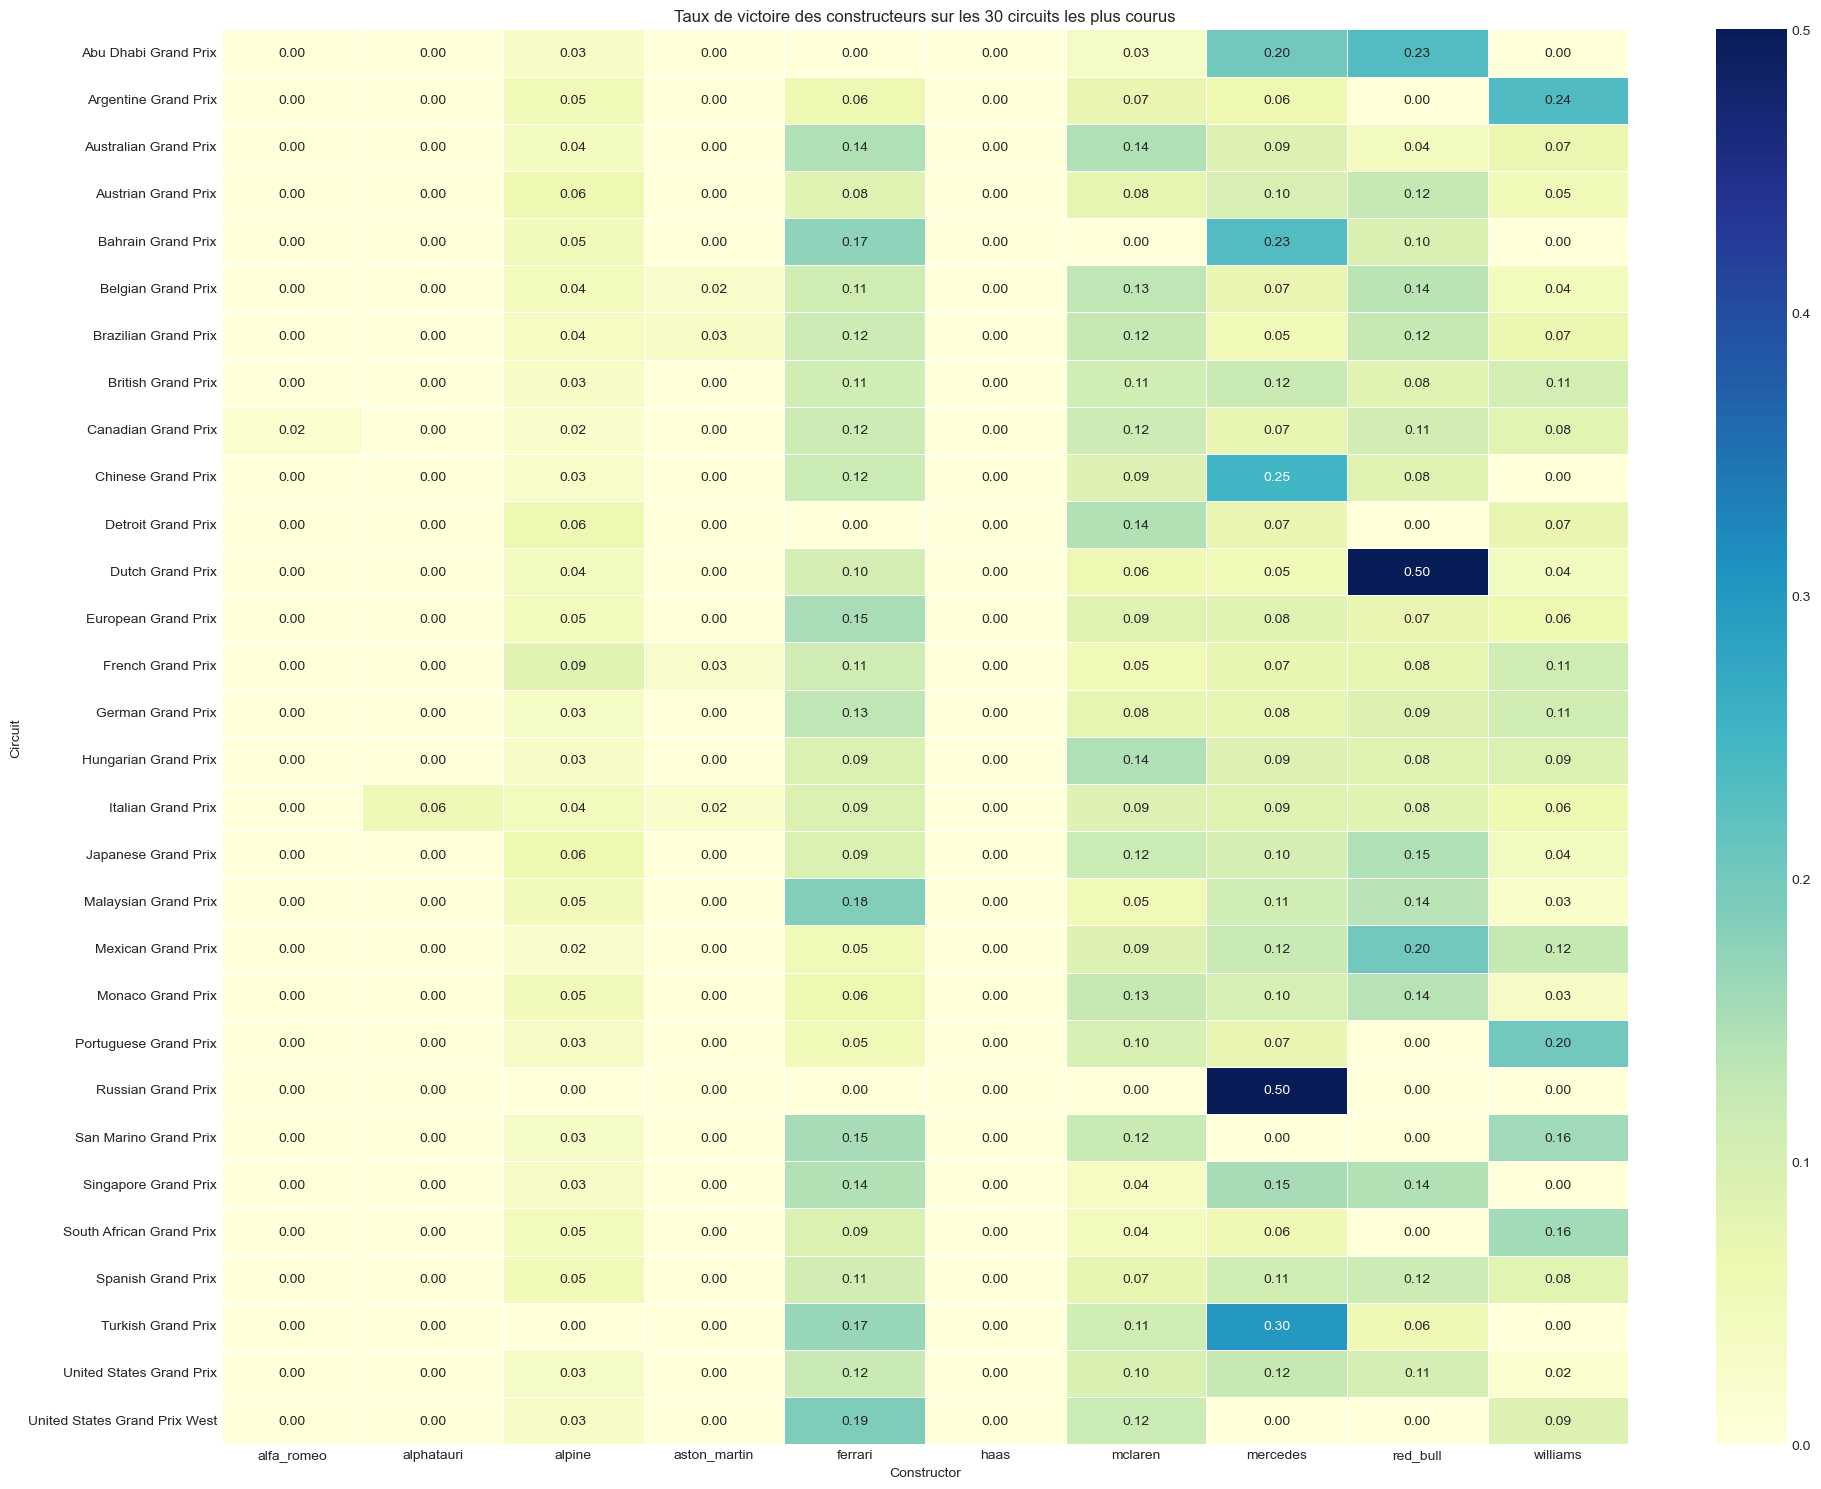

In [243]:
# Vérifier que 'position_driver' est numérique
df_merged["position_driver"] = pd.to_numeric(df_merged["position_driver"], errors='coerce')

# Si la colonne 'is_win' n'existe pas, la créer
if "is_win" not in df_merged.columns:
    df_merged["is_win"] = (df_merged["position_driver"] == 1).astype(int)

# Compter le nombre de courses par circuit
circuit_counts = df_merged.groupby("name_x")["raceId"].nunique().sort_values(ascending=False)

# Garder les 30 circuits les plus courus
top_circuits = circuit_counts.head(30).index.tolist()
df_top = df_merged[df_merged["name_x"].isin(top_circuits)]

# Calcul du taux de victoire par constructeur et par circuit
summary = df_top.groupby(["name_x", "constructor_current"]).agg(
    total_races=("raceId", "count"),
    wins=("is_win", "sum")
).reset_index()

summary["win_rate"] = summary["wins"] / summary["total_races"]

# Pivot pour la heatmap : circuits en lignes, constructeurs en colonnes
heatmap_data = summary.pivot(index="name_x", columns="constructor_current", values="win_rate").fillna(0)

# Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".2f")
plt.title("Taux de victoire des constructeurs sur les 30 circuits les plus courus")
plt.ylabel("Circuit")
plt.xlabel("Constructor")
plt.tight_layout()
plt.show()


Pour reprendre l'exemple du circuit du Mexique, on s'aperçoit que les voitures de Redbull ont tendance à être meilleures que les autres. Donc un circuit en altitude serait propice pour Redbull.

Maintenant intéressons-nous à l'influence de la nationalité de l'écurie sur le taux de victoire

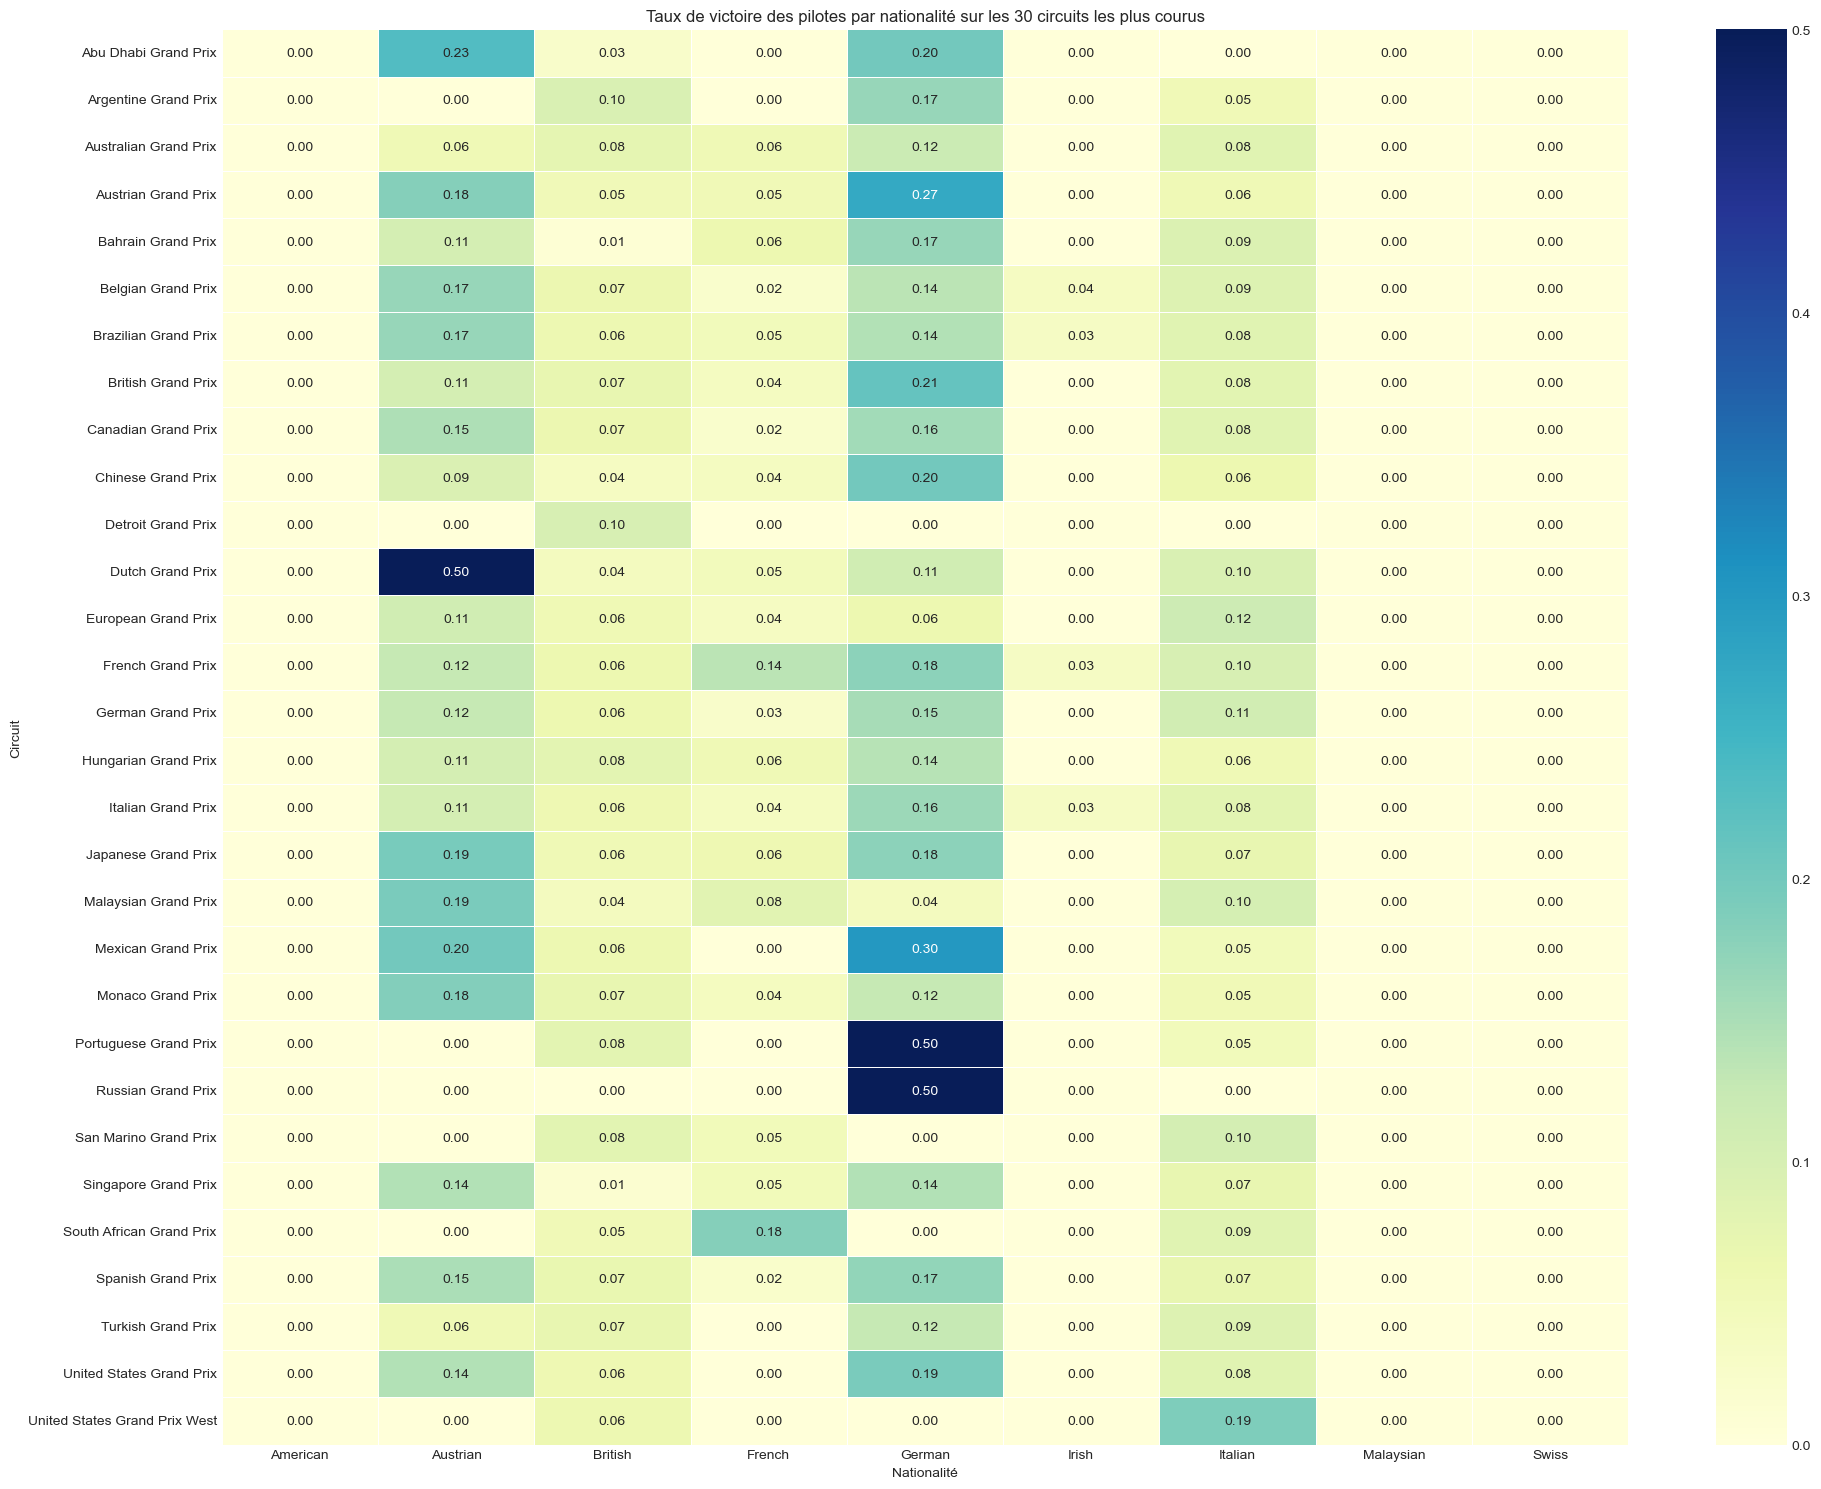

In [249]:
# Compter le nombre de courses par circuit
circuit_counts = df_merged.groupby("name_x")["raceId"].nunique().sort_values(ascending=False)

# Garder les 30 circuits les plus courus
top_circuits = circuit_counts.head(30).index.tolist()
df_top = df_merged[df_merged["name_x"].isin(top_circuits)]

# Calcul du taux de victoire par nationalité et par circuit
summary = df_top.groupby(["name_x", "nationality_y"]).agg(
    total_races=("raceId", "count"),
    wins=("is_win", "sum")
).reset_index()

summary["win_rate"] = summary["wins"] / summary["total_races"]

# Pivot pour la heatmap : circuits en lignes, nationalités en colonnes
heatmap_data = summary.pivot(index="name_x", columns="nationality_y", values="win_rate").fillna(0)

# Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".2f")
plt.title("Taux de victoire des pilotes par nationalité sur les 30 circuits les plus courus")
plt.ylabel("Circuit")
plt.xlabel("Nationalité")
plt.tight_layout()
plt.show()

On s'aperçoit que l'Allemagne domine certains circuits, notament grâce à Mercedes et que l'Autriche se défend bien également par l'intermédaire de Redbull.